In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import const as CONST
from utils import read_csv_ts
from darts import TimeSeries
import matplotlib
from datasets import SeqDataset, Datasets, DatasetAccesor, DatasetTransformer, load_datasets
import seaborn as sns

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (20, 10)
COLORS = [
    "red", "green", "blue", "purple", "cyan", "olive", "gray", "brown", "pink"
]

In [2]:
ds = load_datasets()

INFO:Dataset:Loading dataset from data/preprocessed/datasets.pkl


In [3]:
print(f"Data starts: {ds.original.series[0].start_time()}")
print(f"Data ends: {ds.original.series[0].end_time()}, len = {len(ds.original.series[0])}")
print(f"Train data starts: {ds.original.train[0].start_time()}, len = {len(ds.original.train[0])}")
print(f"Validation data starts: {ds.original.val[0].start_time()}, len = {len(ds.original.val[0])}")
print(f"Test data starts: {ds.original.test[0].start_time()}, len = {len(ds.original.test[0])}")

Data starts: 2008-01-02 09:00:00
Data ends: 2023-03-09 16:00:00, len = 30584
Train data starts: 2008-01-02 09:00:00, len = 24467
Validation data starts: 2020-02-26 12:00:00, len = 3058
Test data starts: 2021-08-31 14:00:00, len = 3059


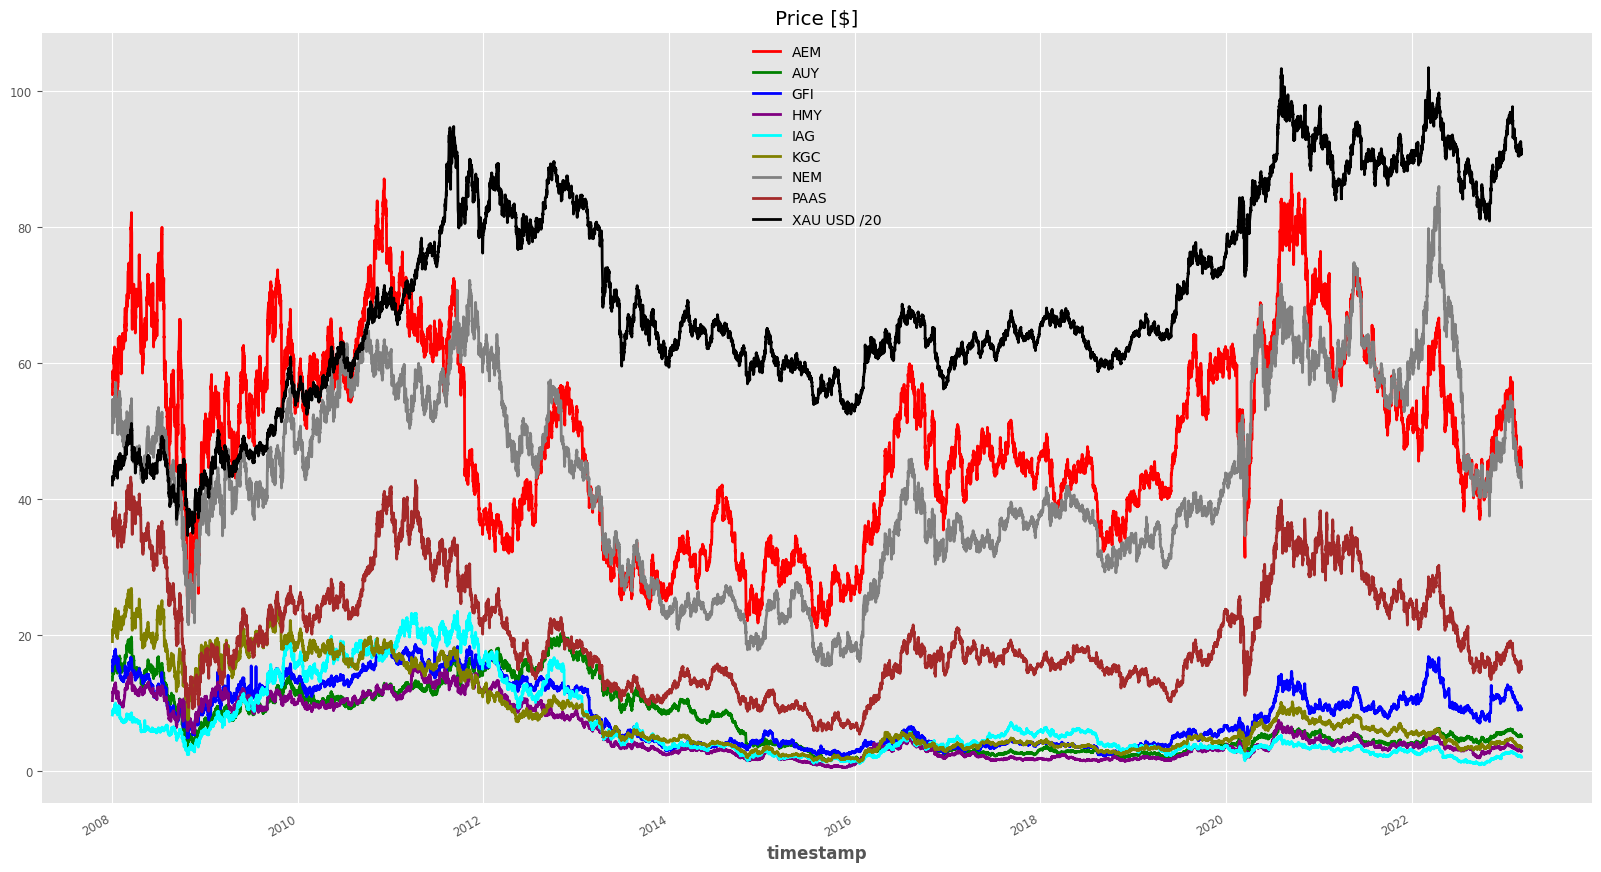

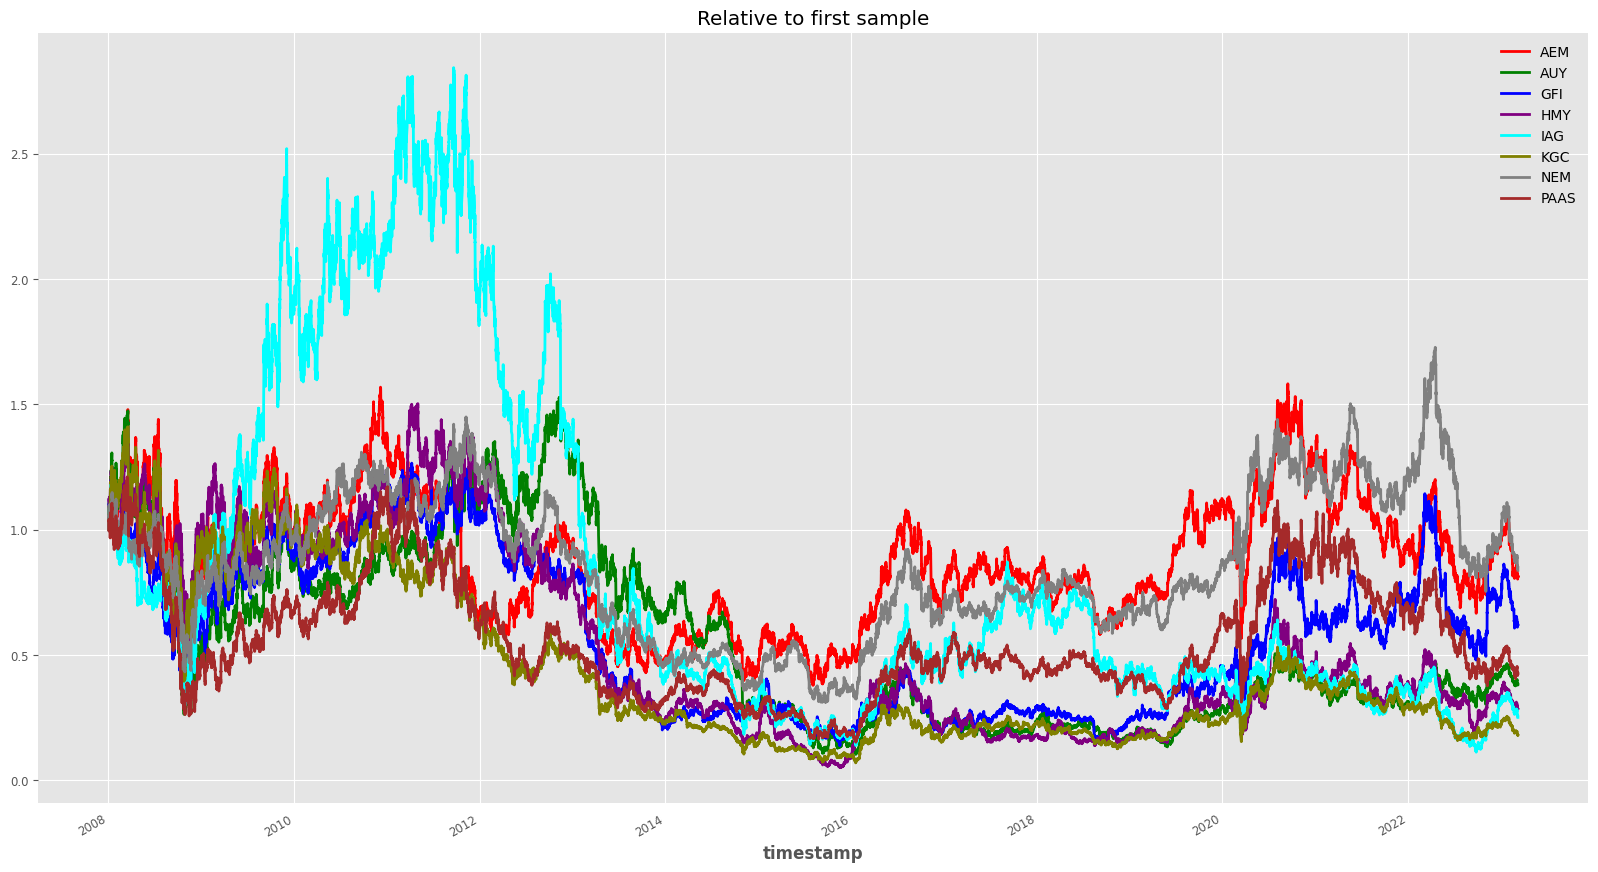

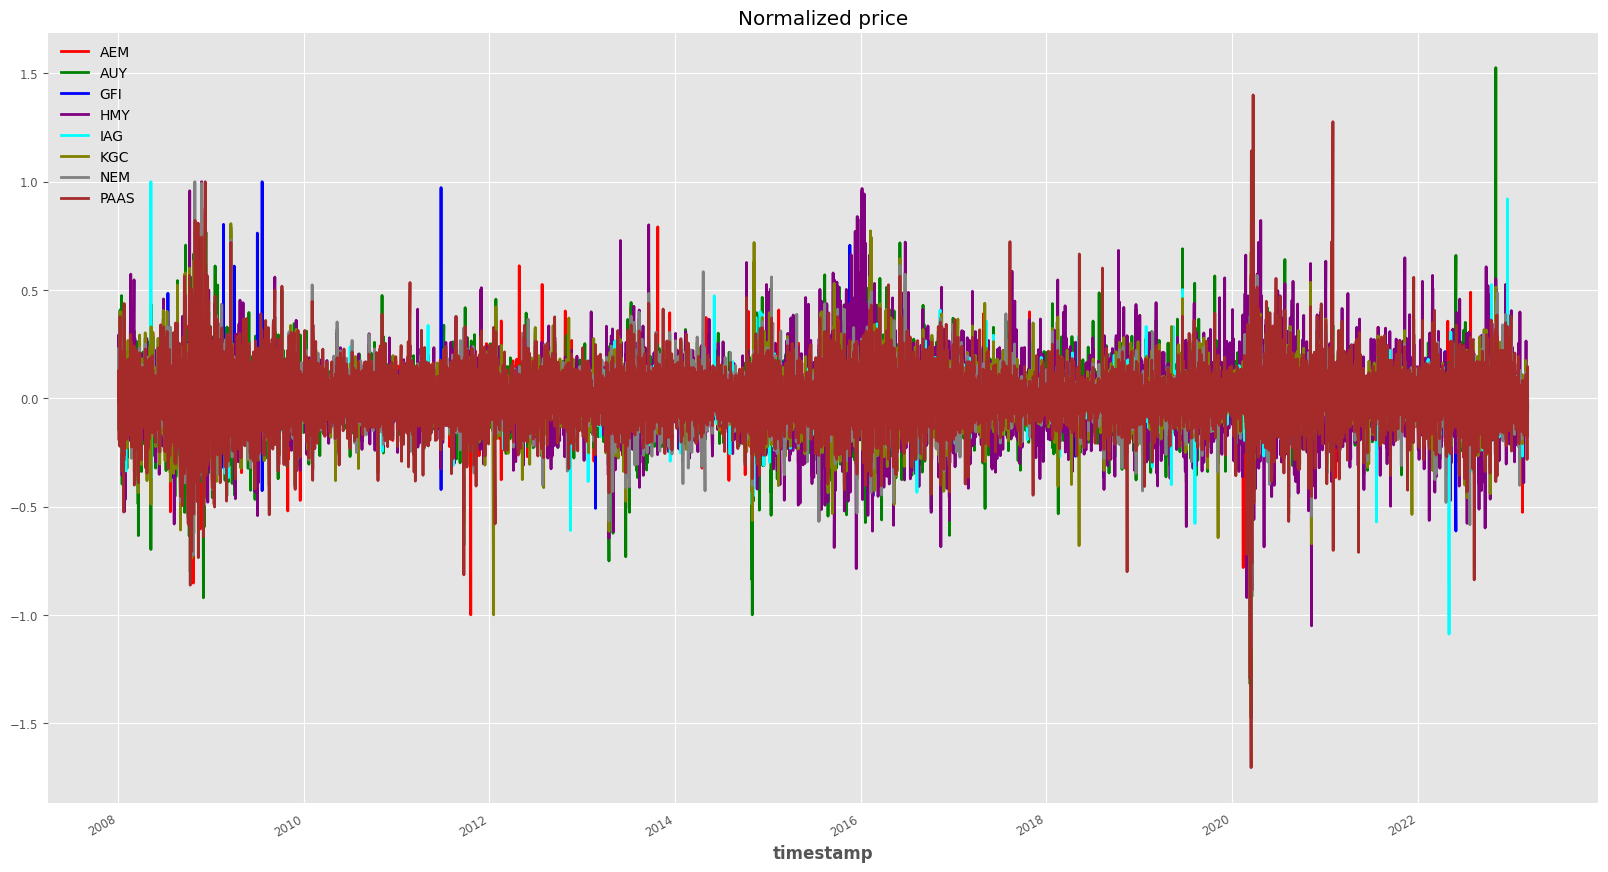

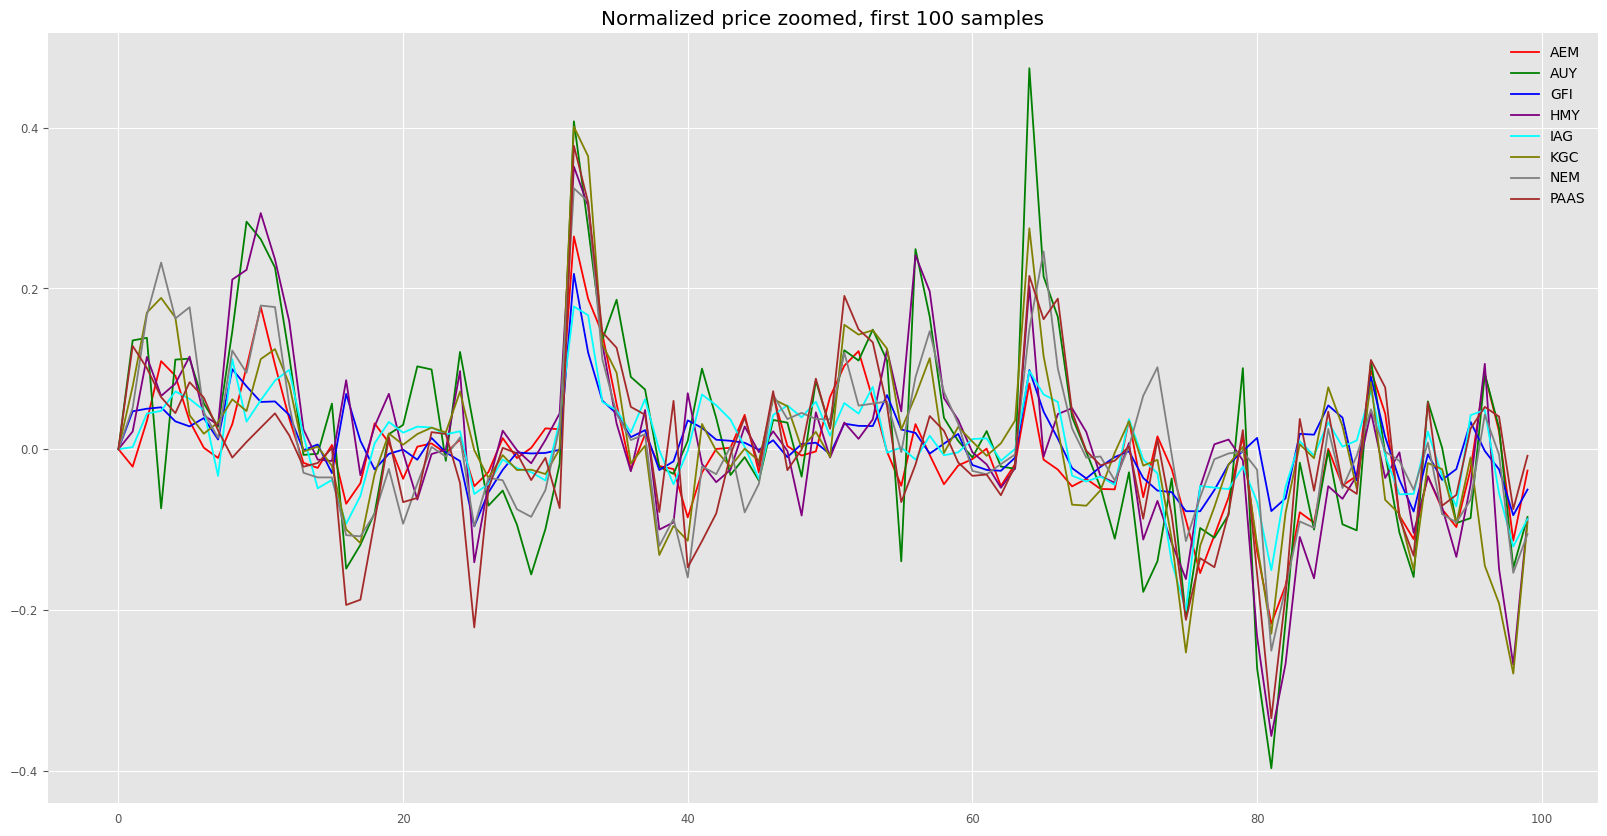

In [4]:
for idx,ticker in enumerate(ds.original.used_tickers):
    ds.original.series[idx].plot(label=ticker,color = COLORS[idx])
gold_ts = TimeSeries.from_dataframe(read_csv_ts("data/merged/gold.csv"))
(gold_ts/20).plot(label="XAU USD /20", color="black")
plt.title("Price [$]")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    (ds.original.series[idx]/ ds.original.series[idx].first_value()).plot(label=ticker, color = COLORS[idx])
plt.title("Relative to first sample")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    ds.transformed.series[idx].plot(label=ticker,color = COLORS[idx])
plt.title("Normalized price")
plt.show()


for idx,ticker in enumerate(ds.original.used_tickers):
    plt.plot(ds.transformed.series[idx][0:100].values(),label=ticker,color = COLORS[idx])
plt.legend(ds.original.used_tickers)
plt.title("Normalized price zoomed, first 100 samples")
plt.show()

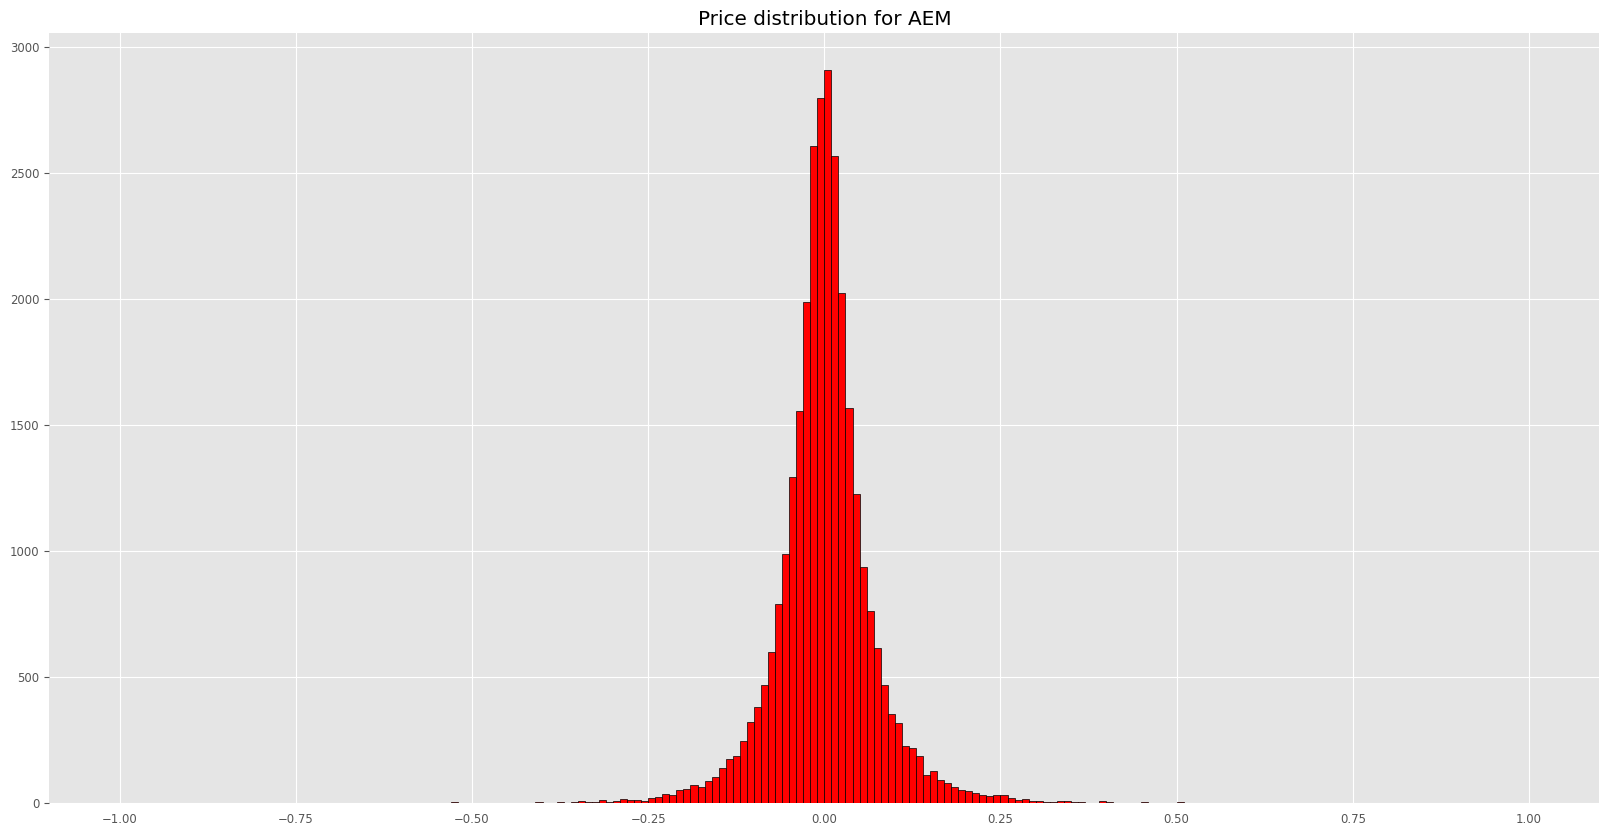

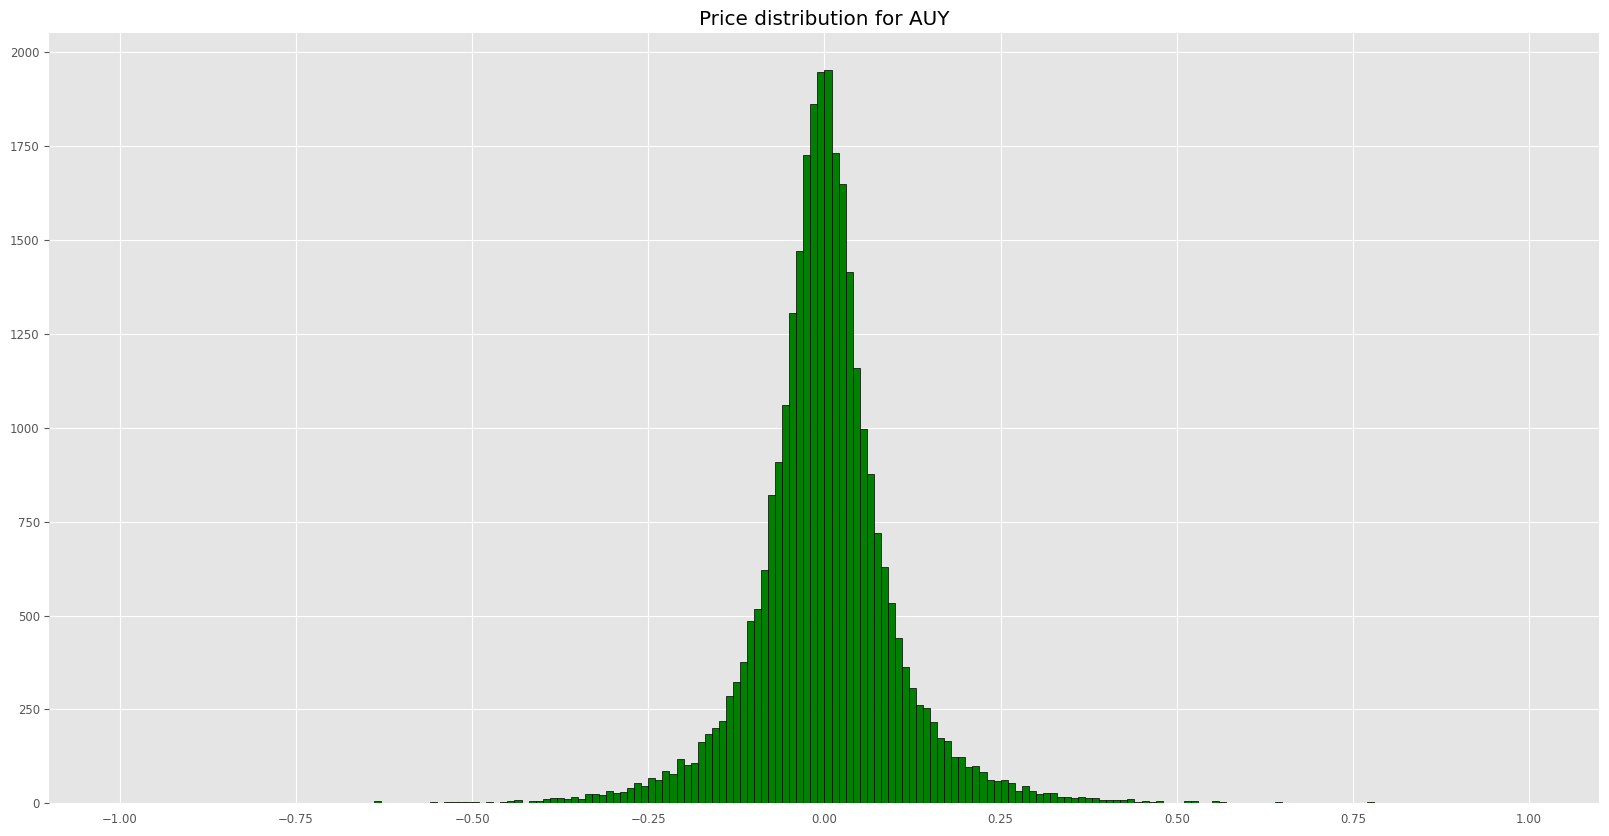

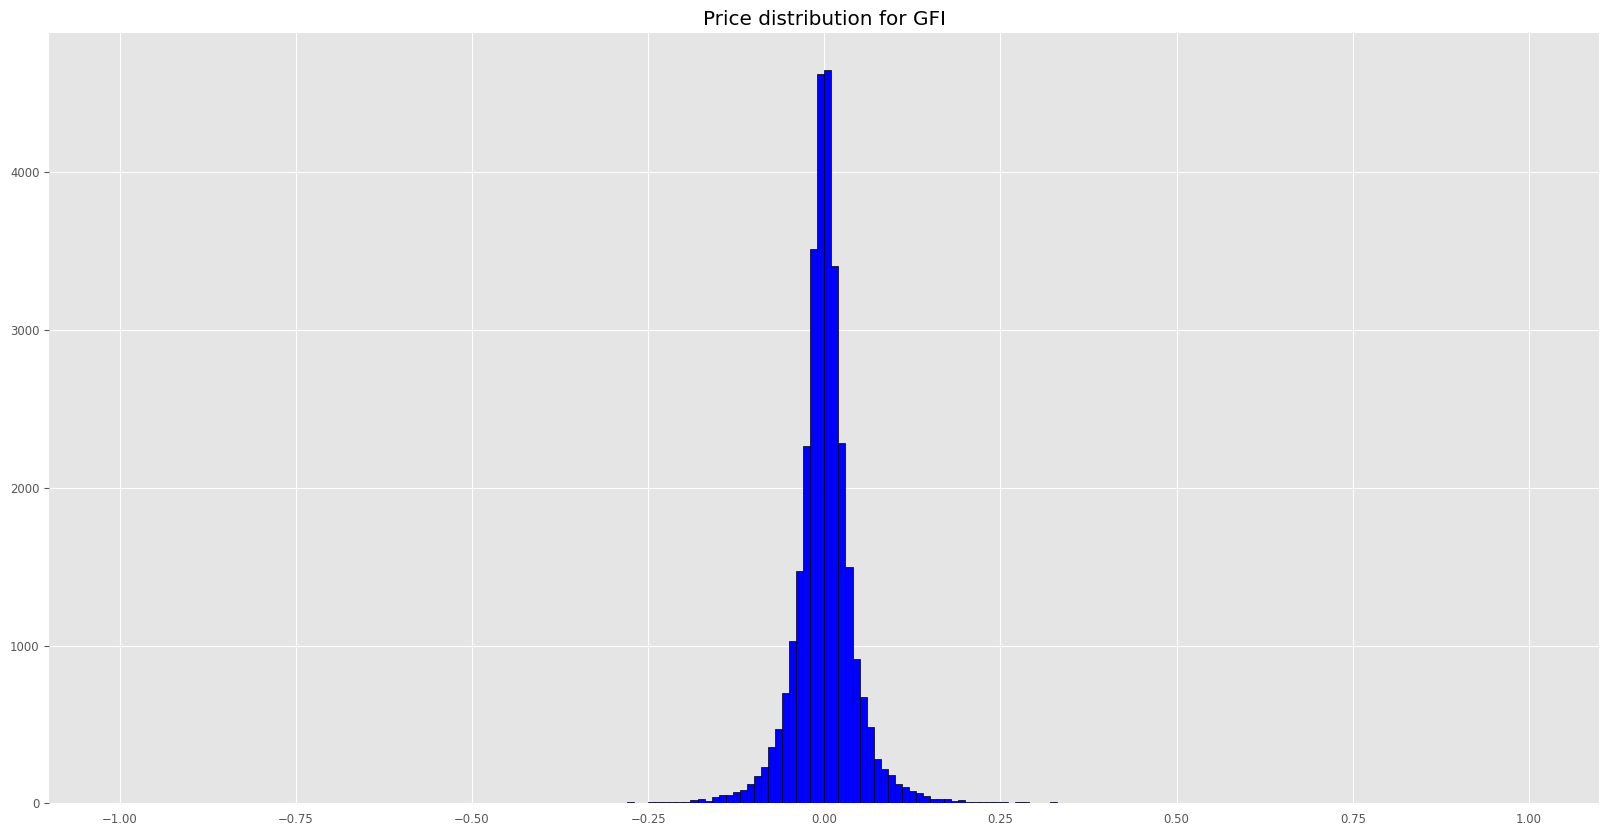

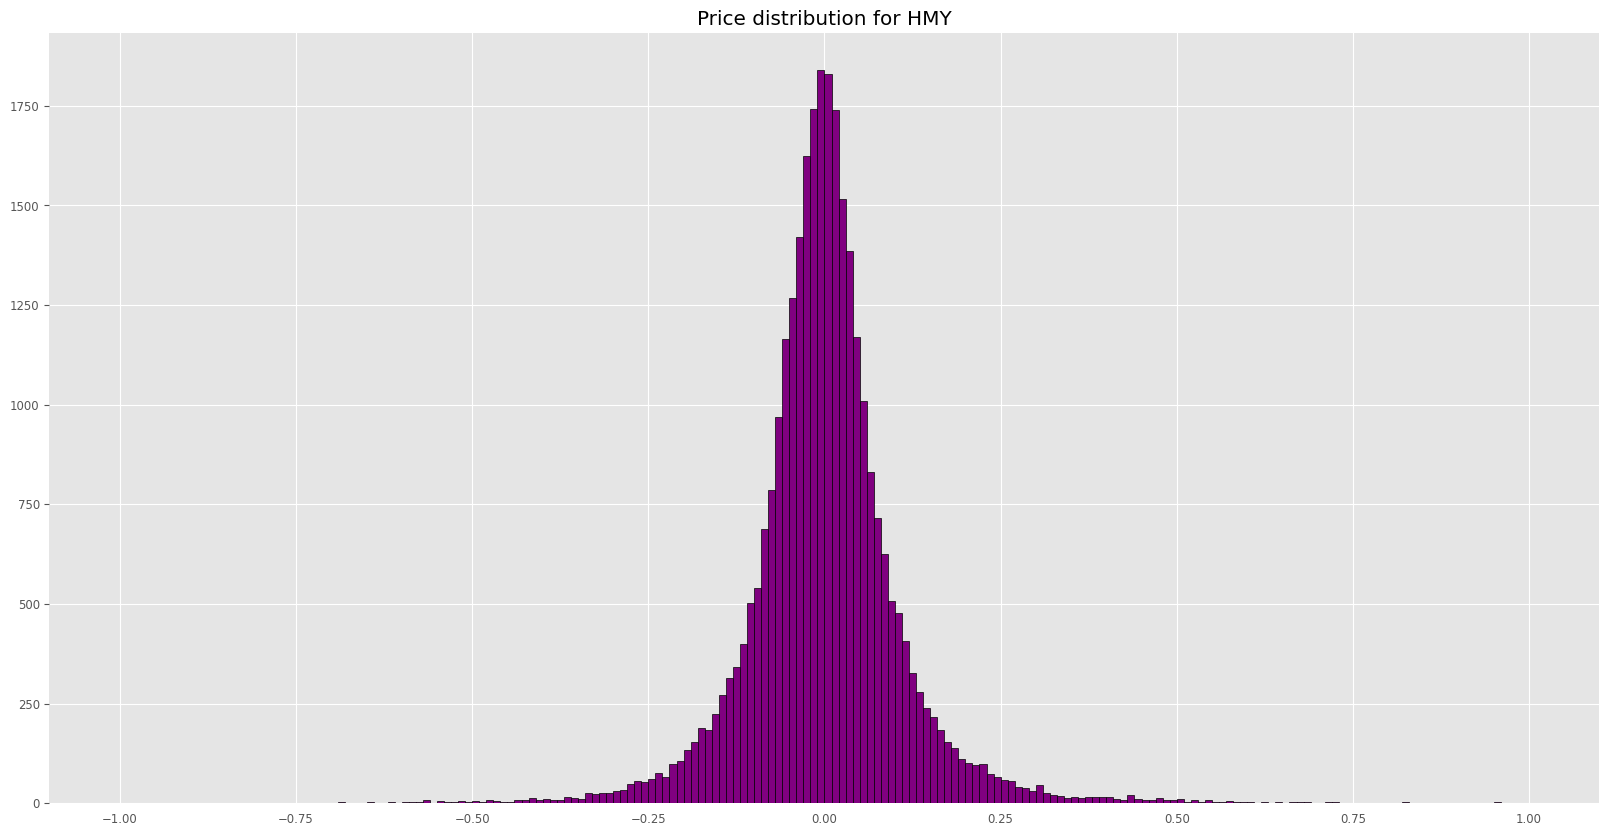

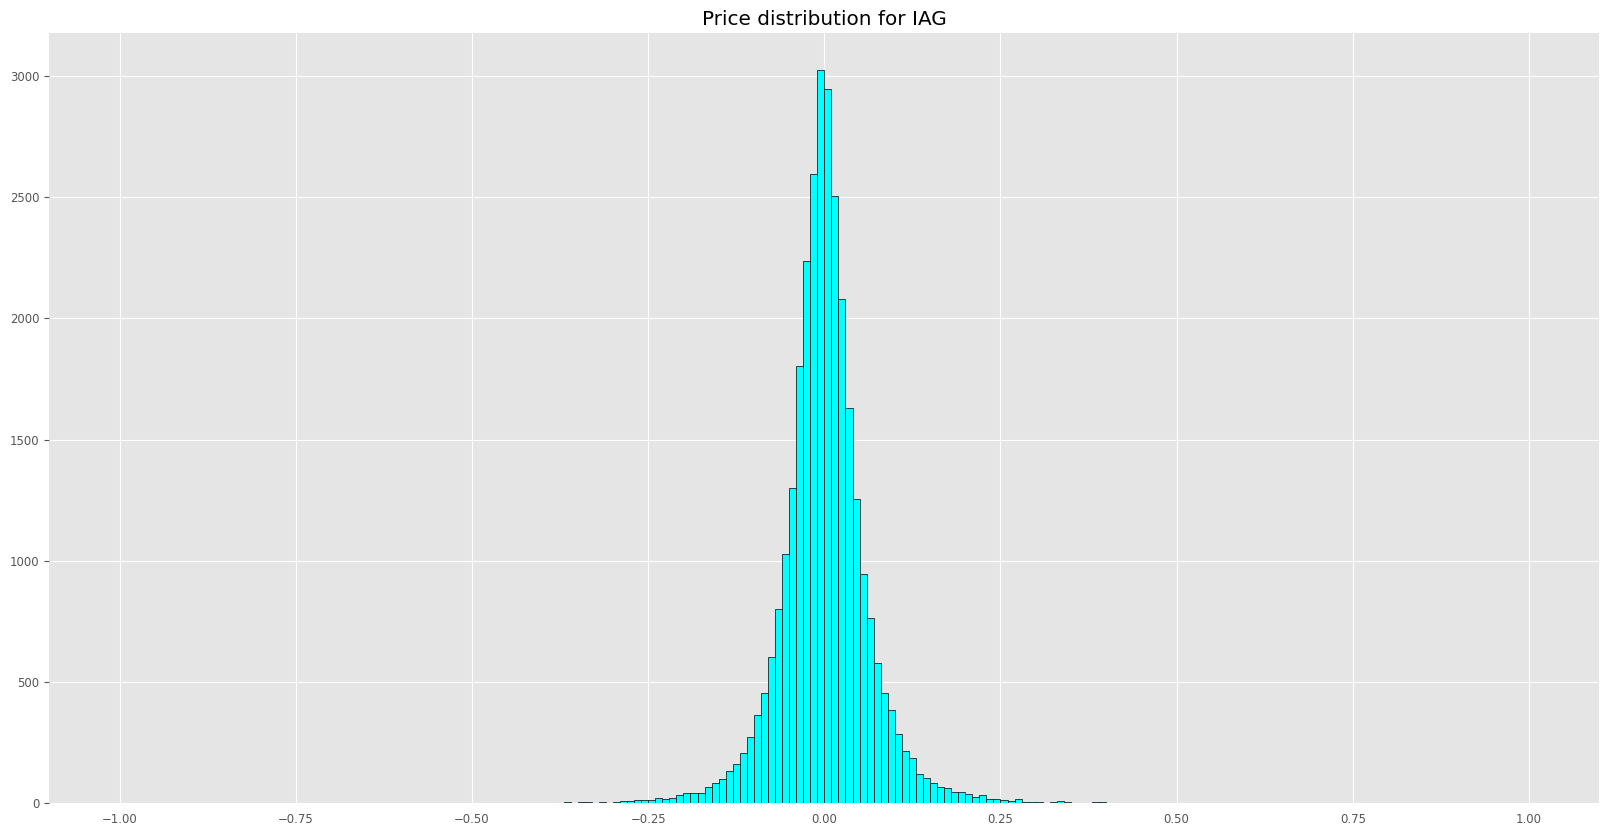

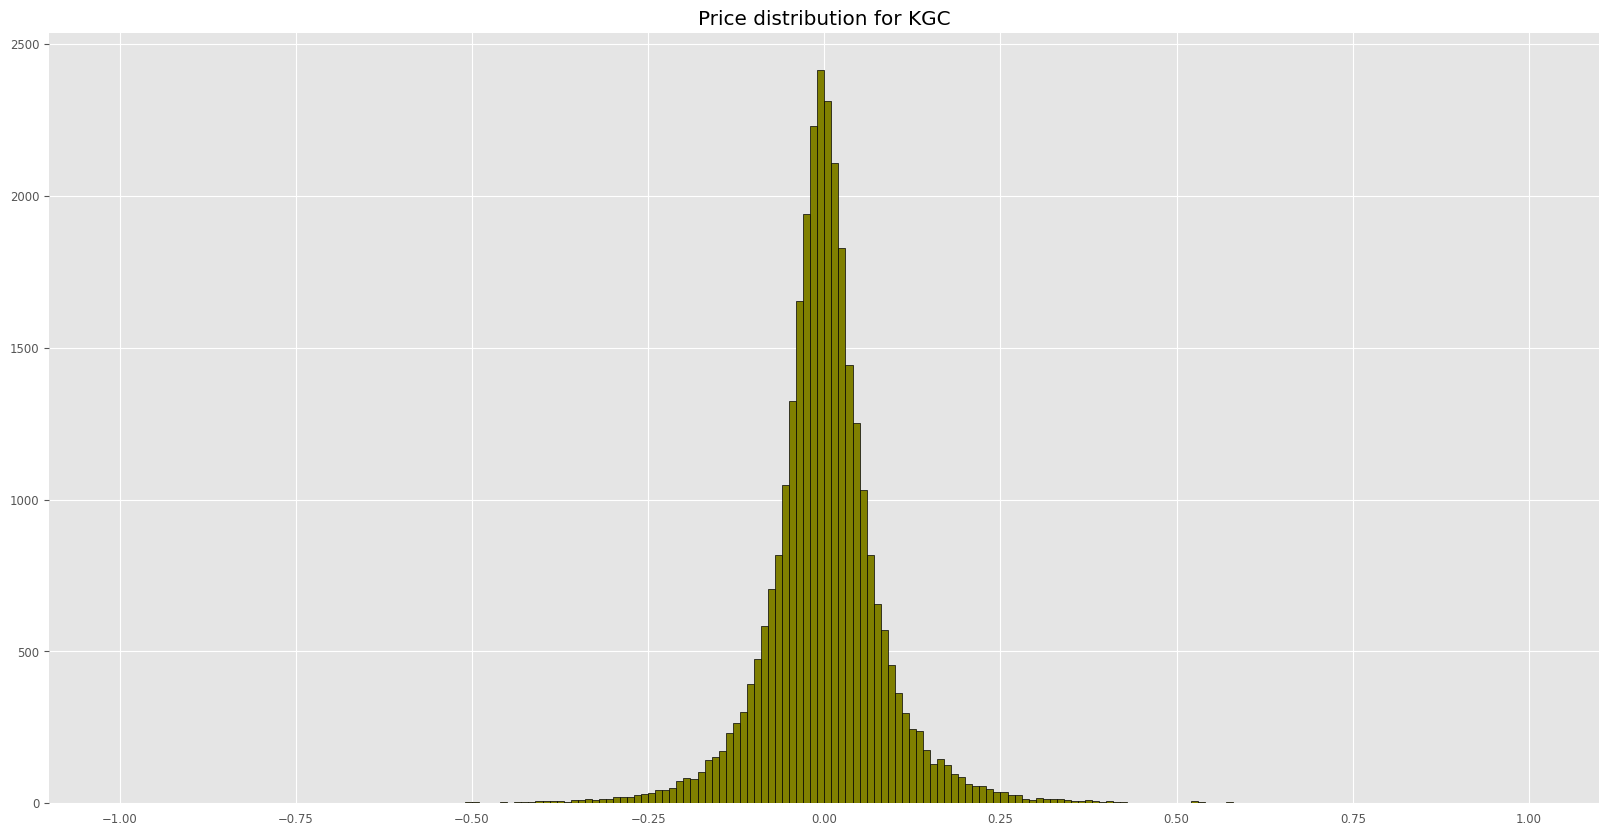

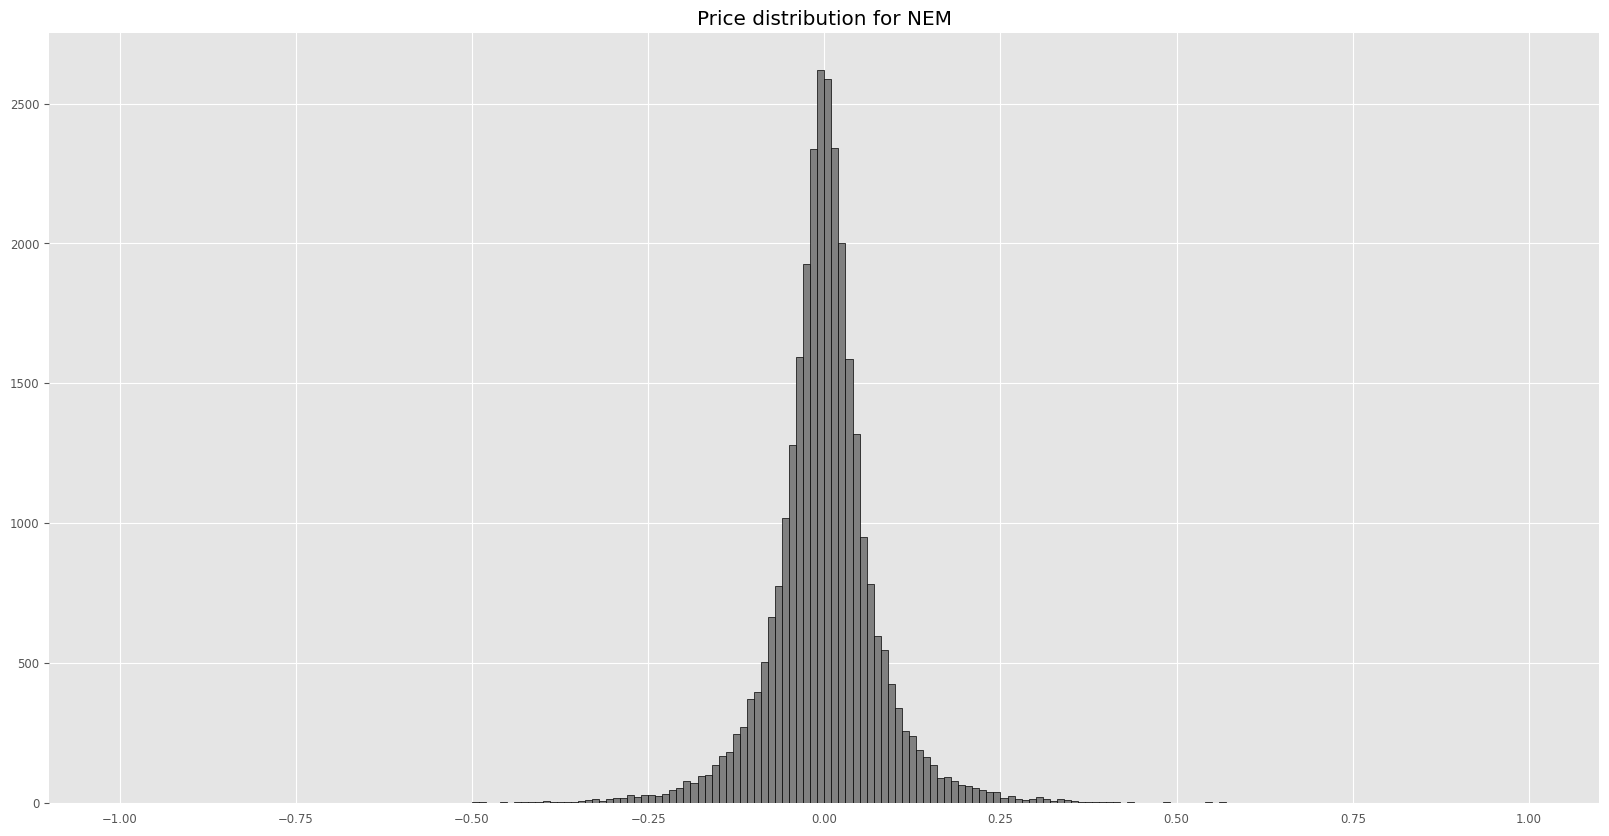

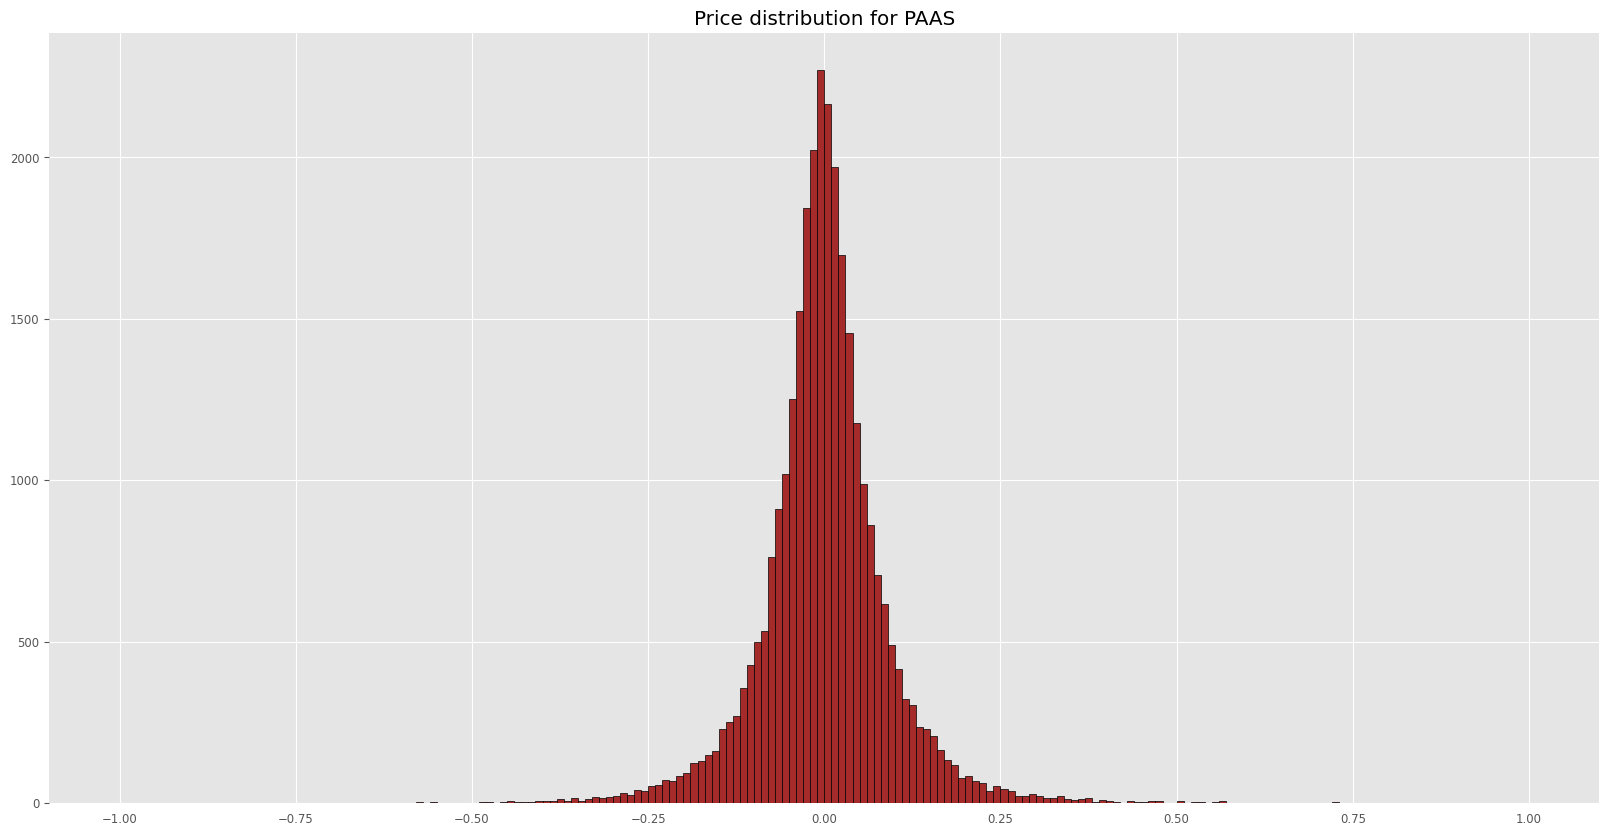

In [5]:
bins= [x / 100 for x in range(-100,101)]
for idx,ticker in enumerate(ds.original.used_tickers):
    plt.hist(ds.transformed.series[idx].values(), bins= bins, color=COLORS[idx], edgecolor='black')
    plt.title("Price distribution for "+ticker)
    plt.show()

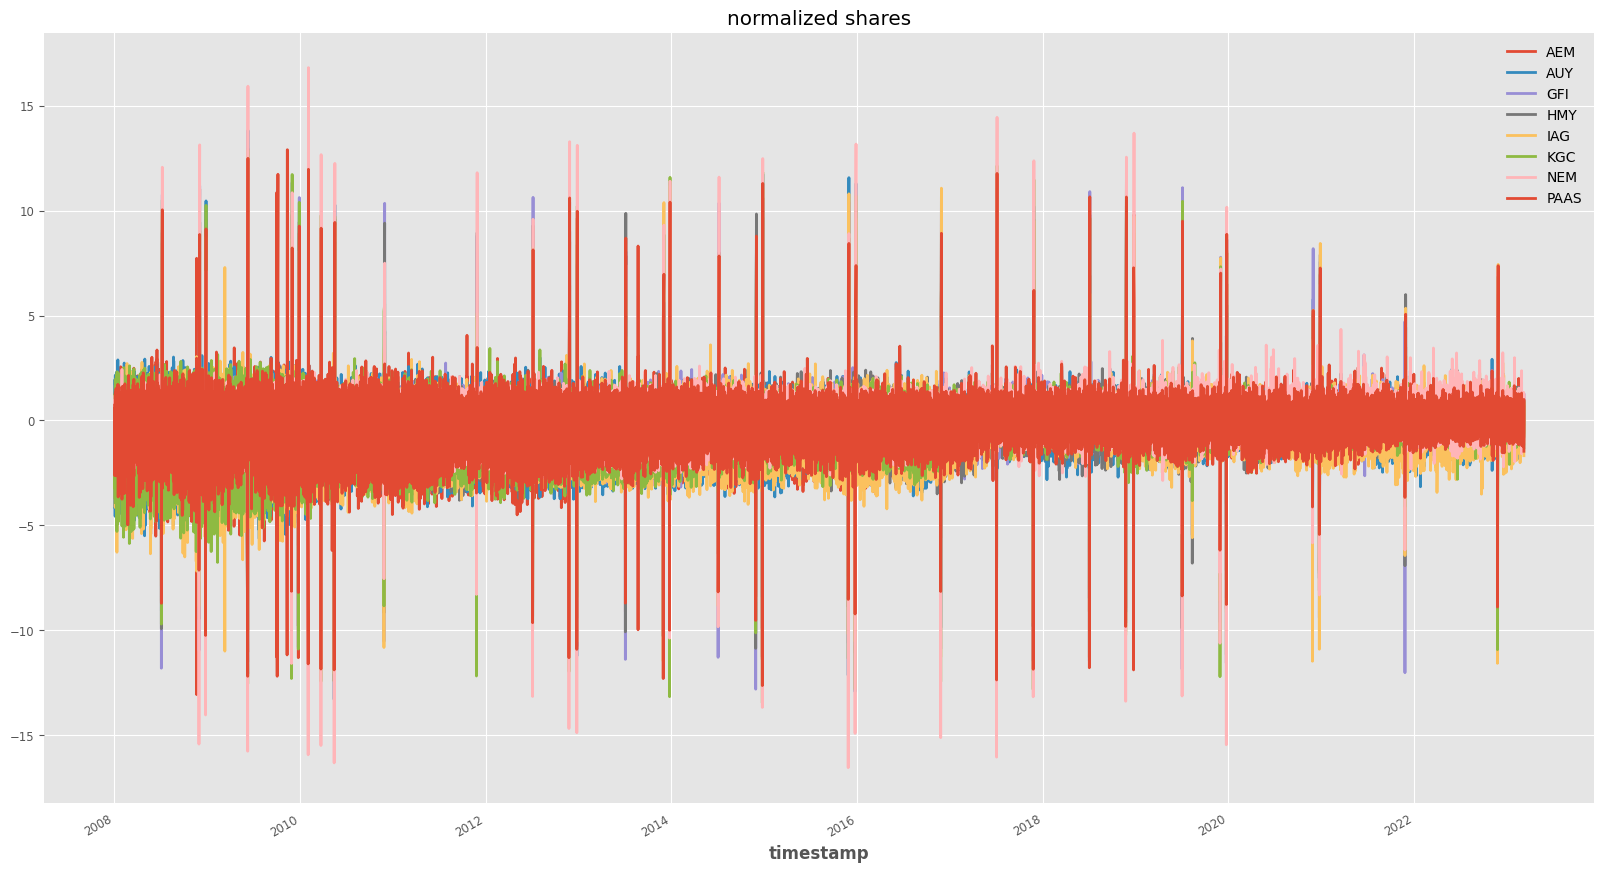

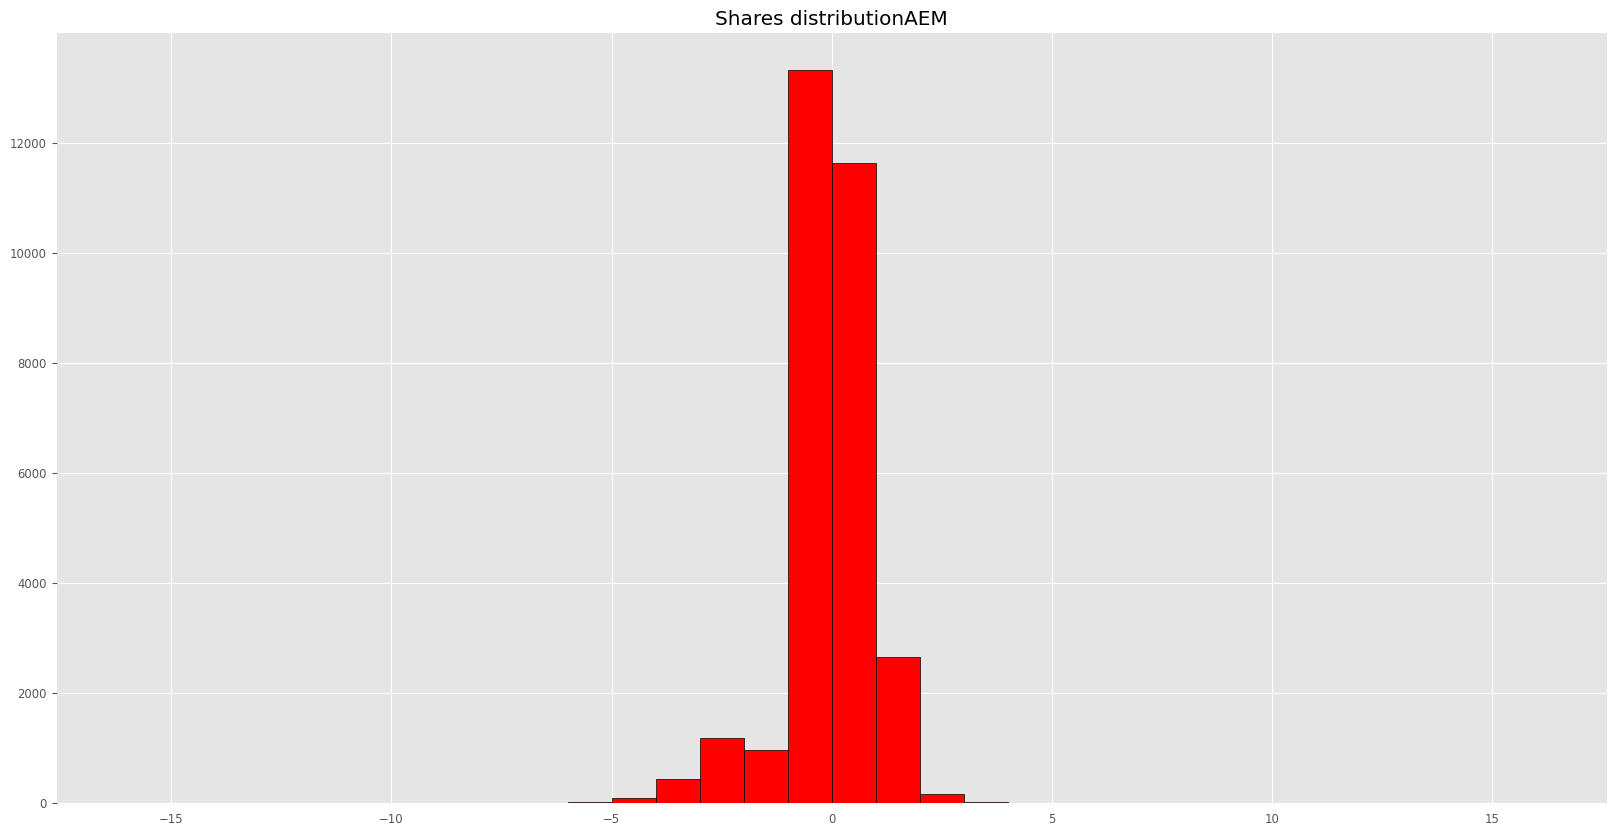

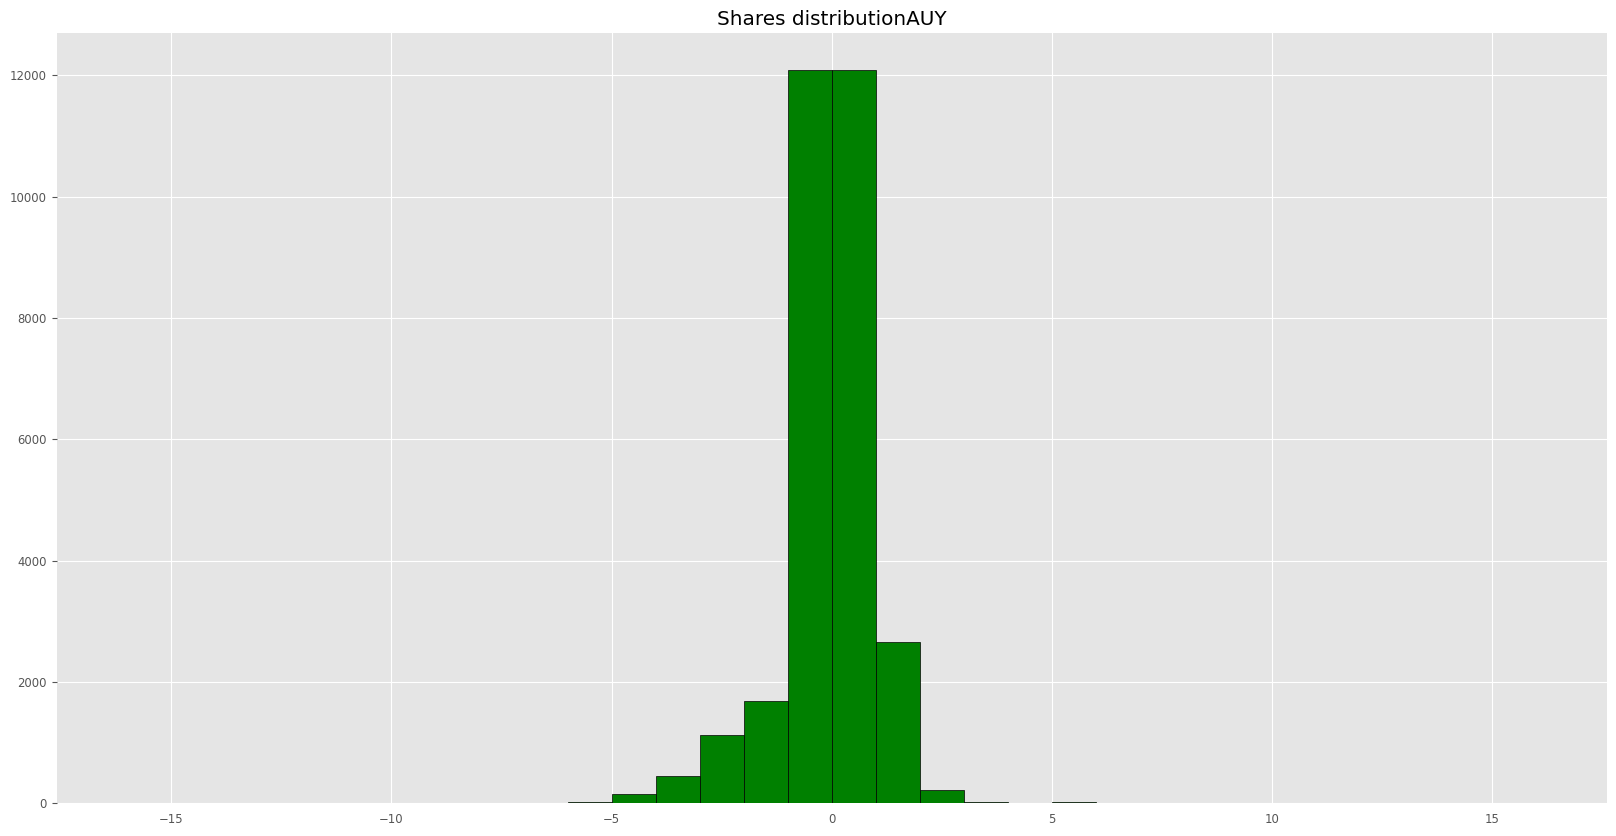

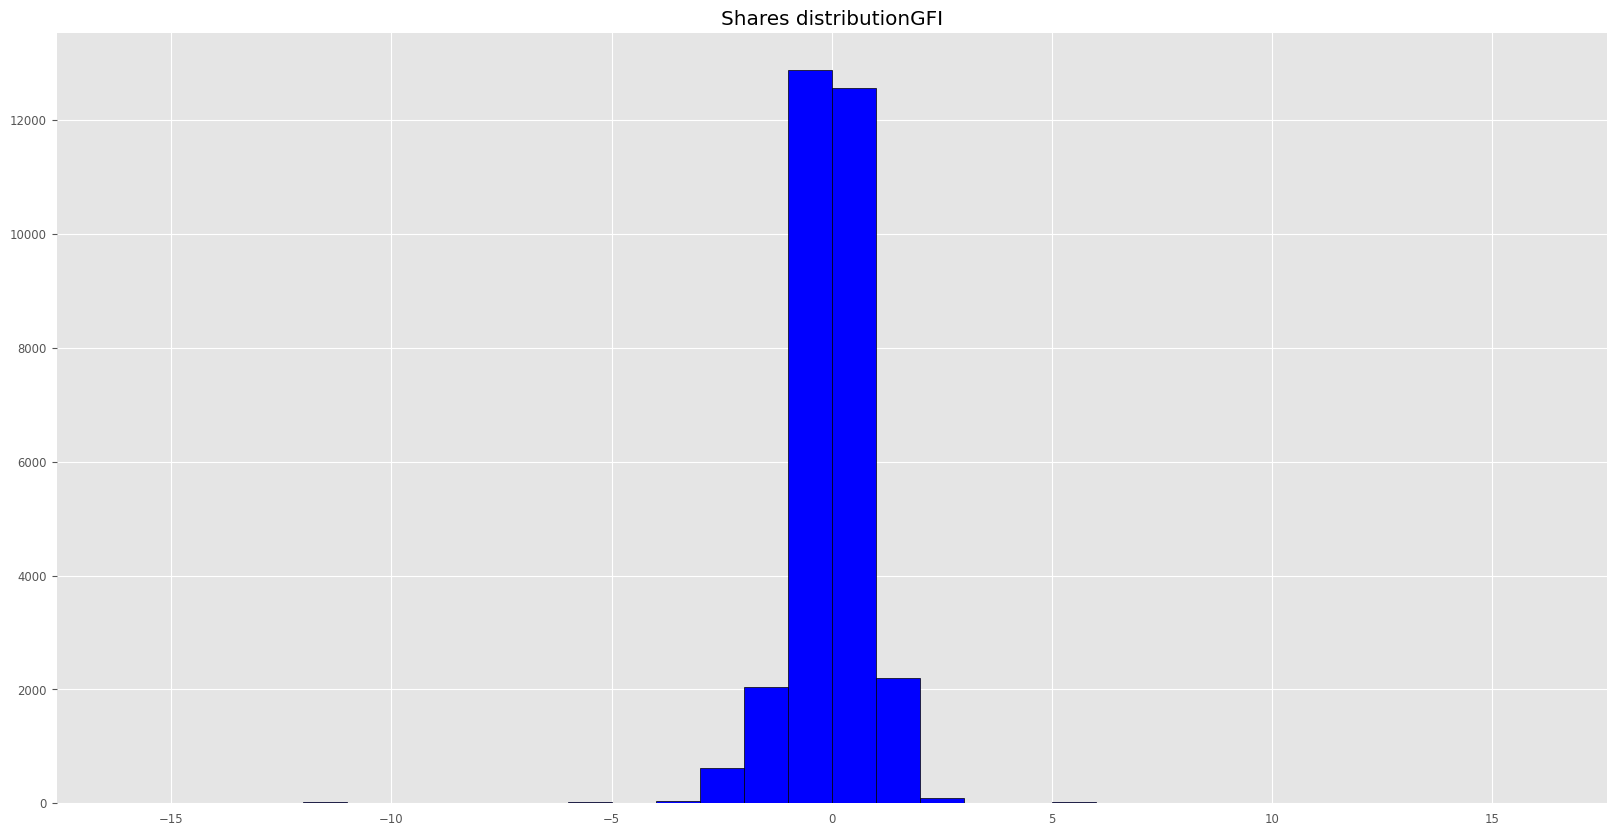

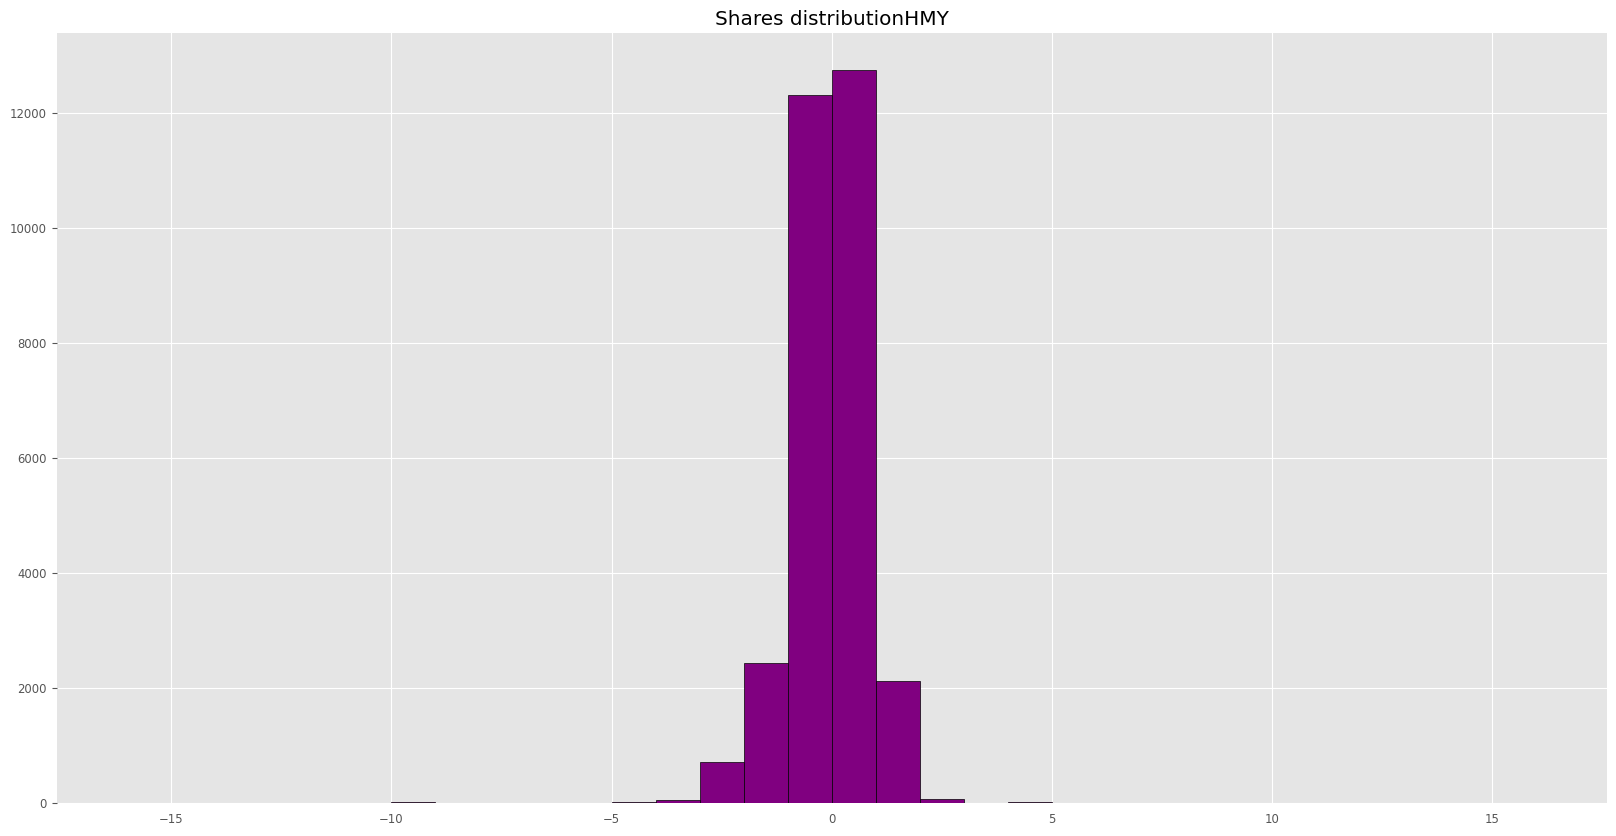

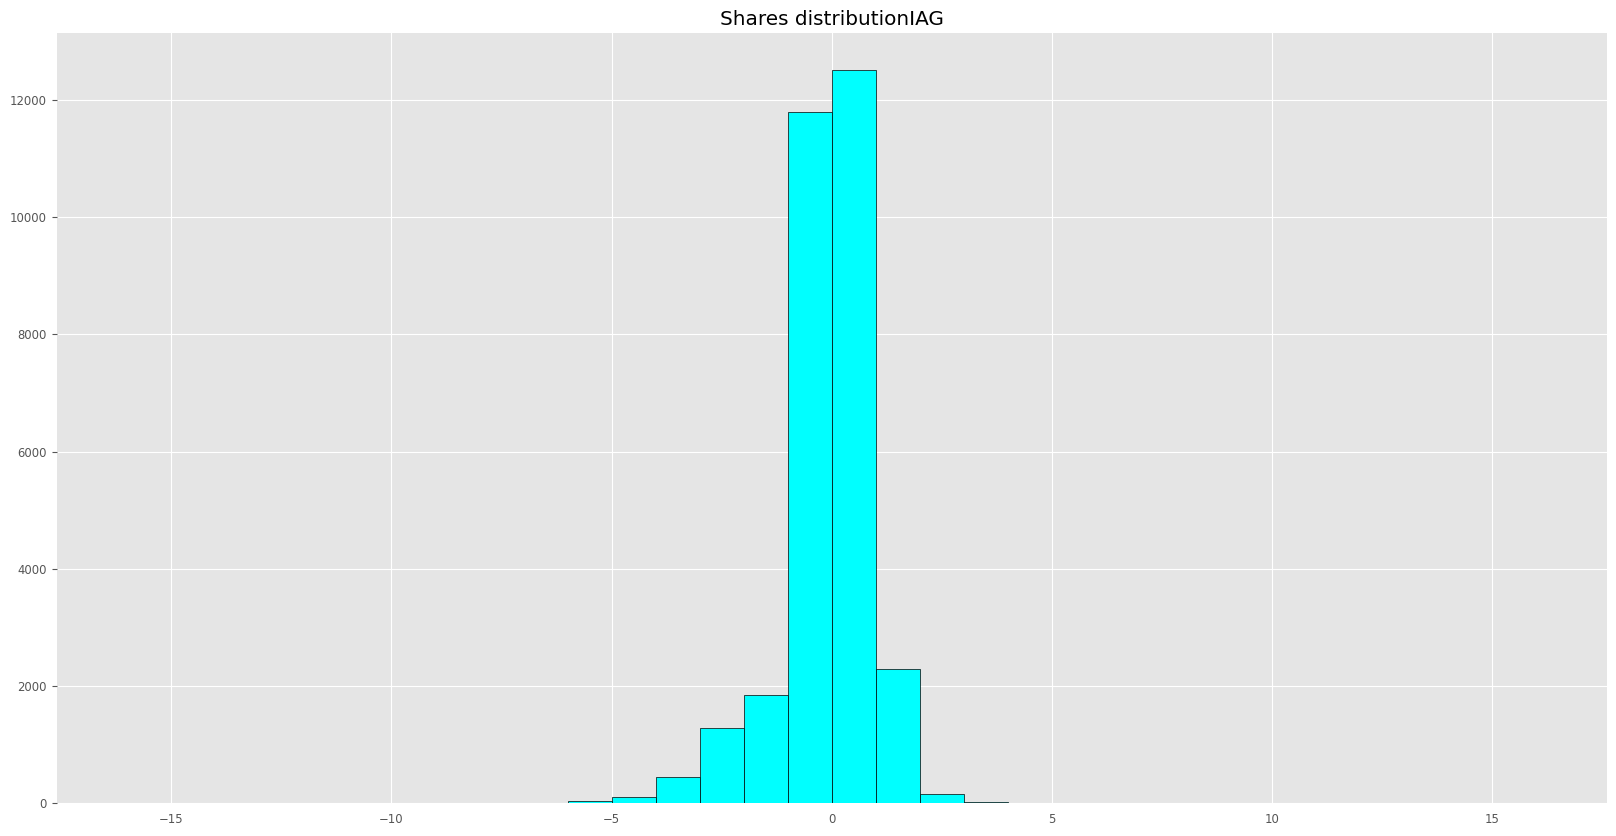

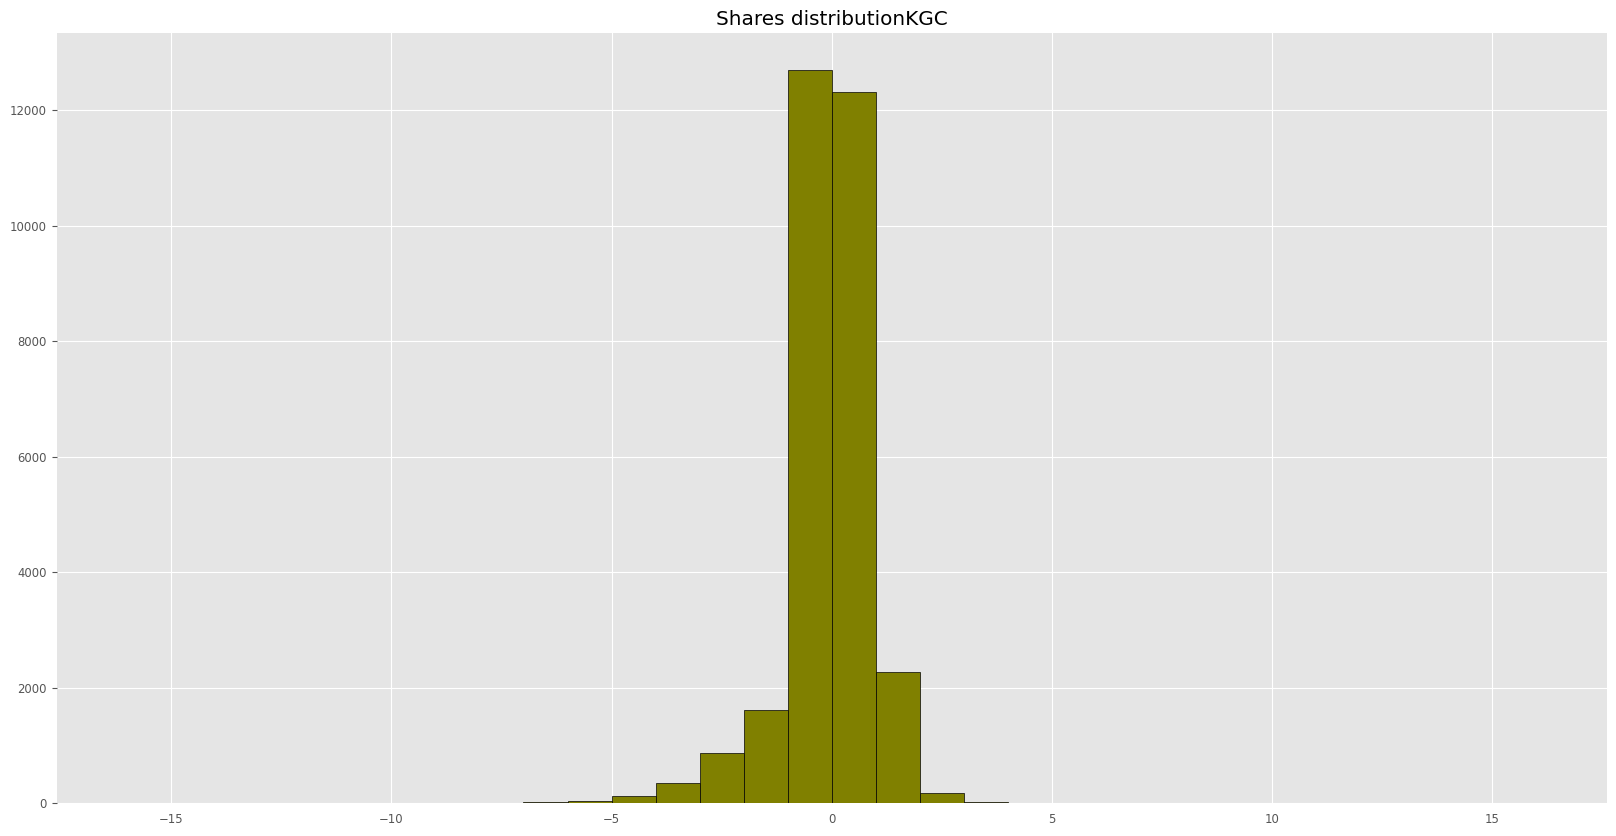

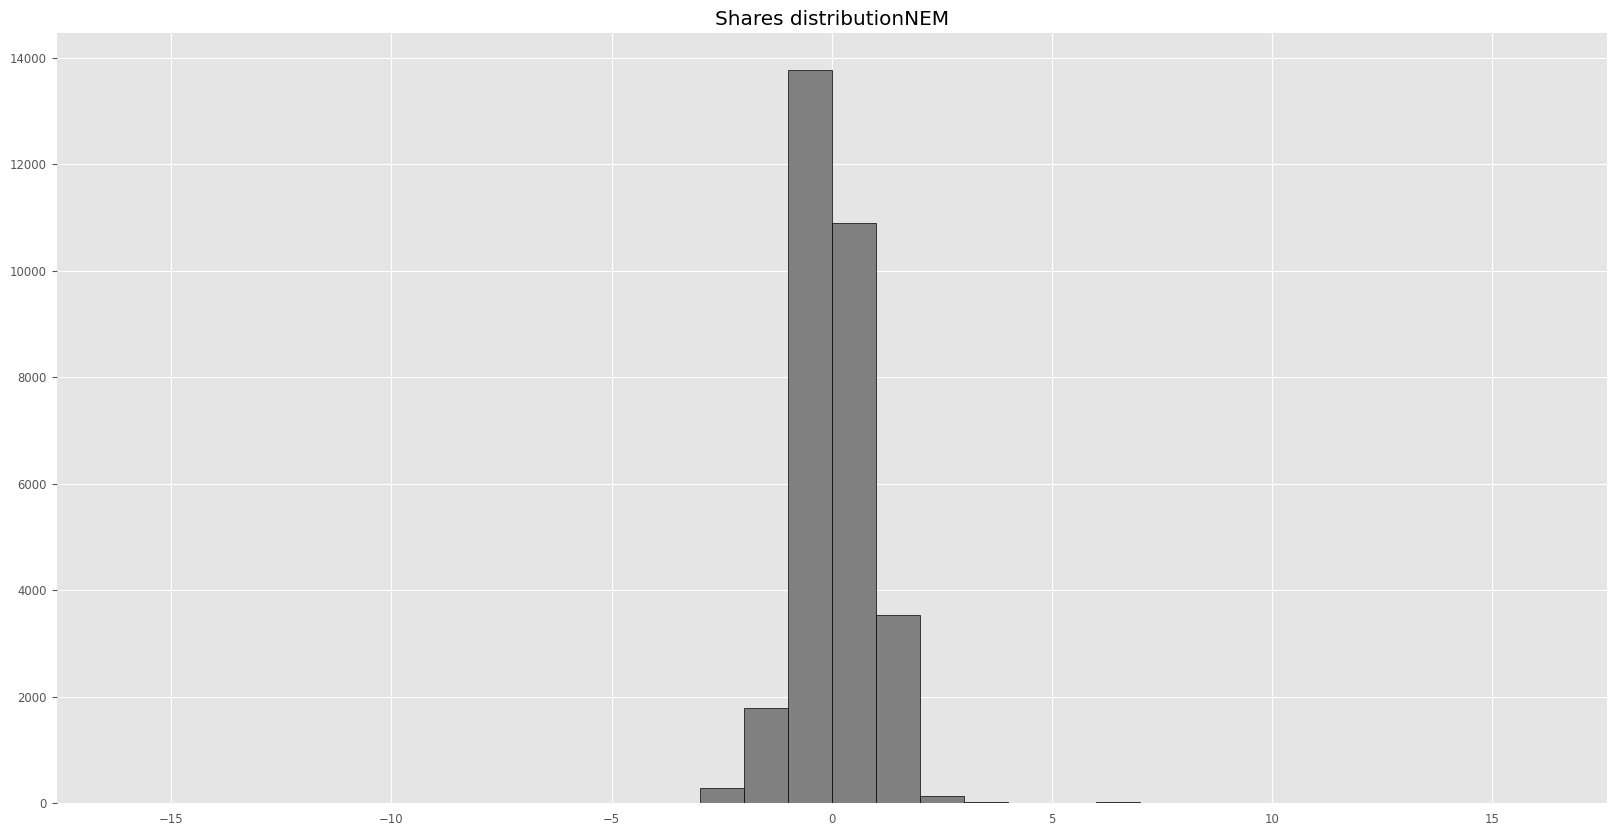

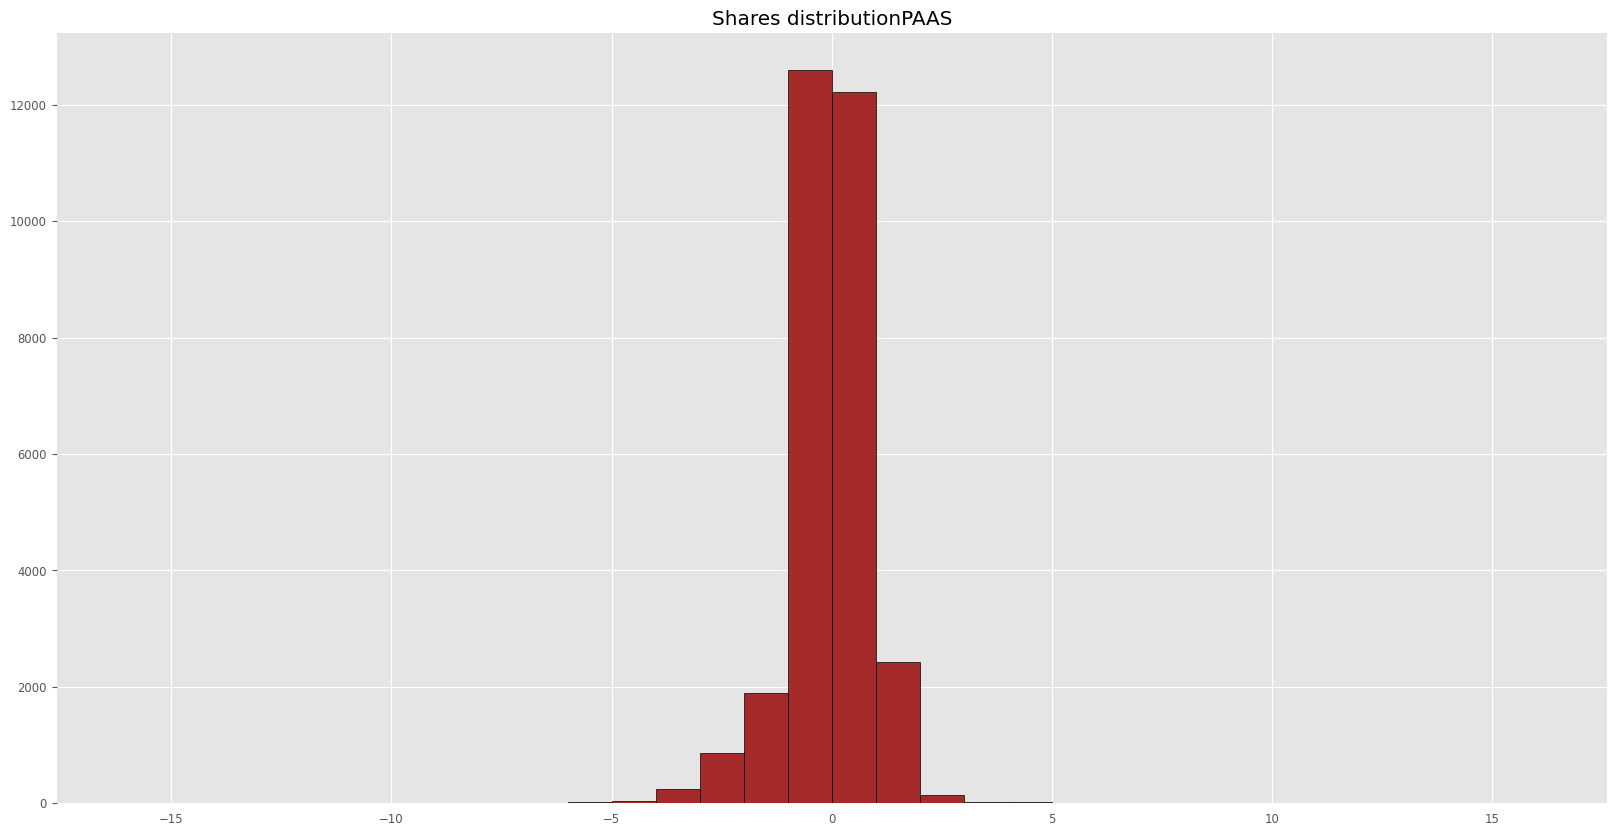

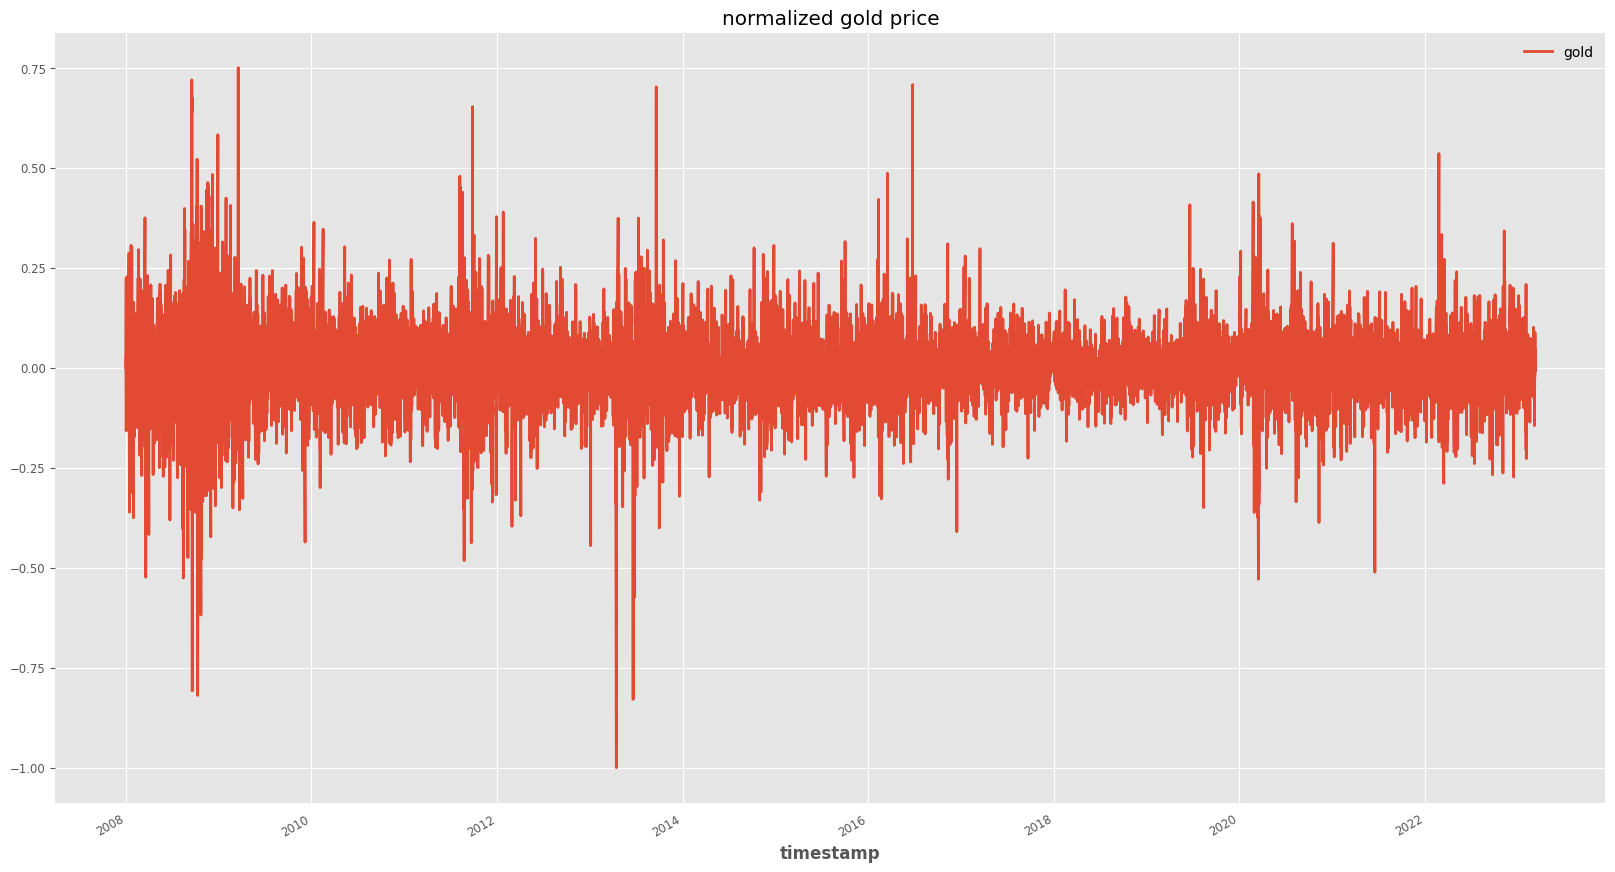

In [6]:
for idx, ticker in enumerate(ds.original.used_tickers):
    ds.covariates.series[idx][CONST.FEATURES.SHARES].plot(label=ticker)
plt.title("normalized shares")
plt.show()


for idx,ticker in enumerate(ds.original.used_tickers):
    plt.hist( ds.covariates.series[idx][CONST.FEATURES.SHARES].values(), bins= [x  for x in range(-16,17)], color=COLORS[idx], edgecolor='black')
    plt.title("Shares distribution" + ticker)
    plt.show()

ds.covariates.series[0][CONST.FEATURES.GOLD_PRICE].plot(label="gold")
plt.title("normalized gold price")
plt.show()

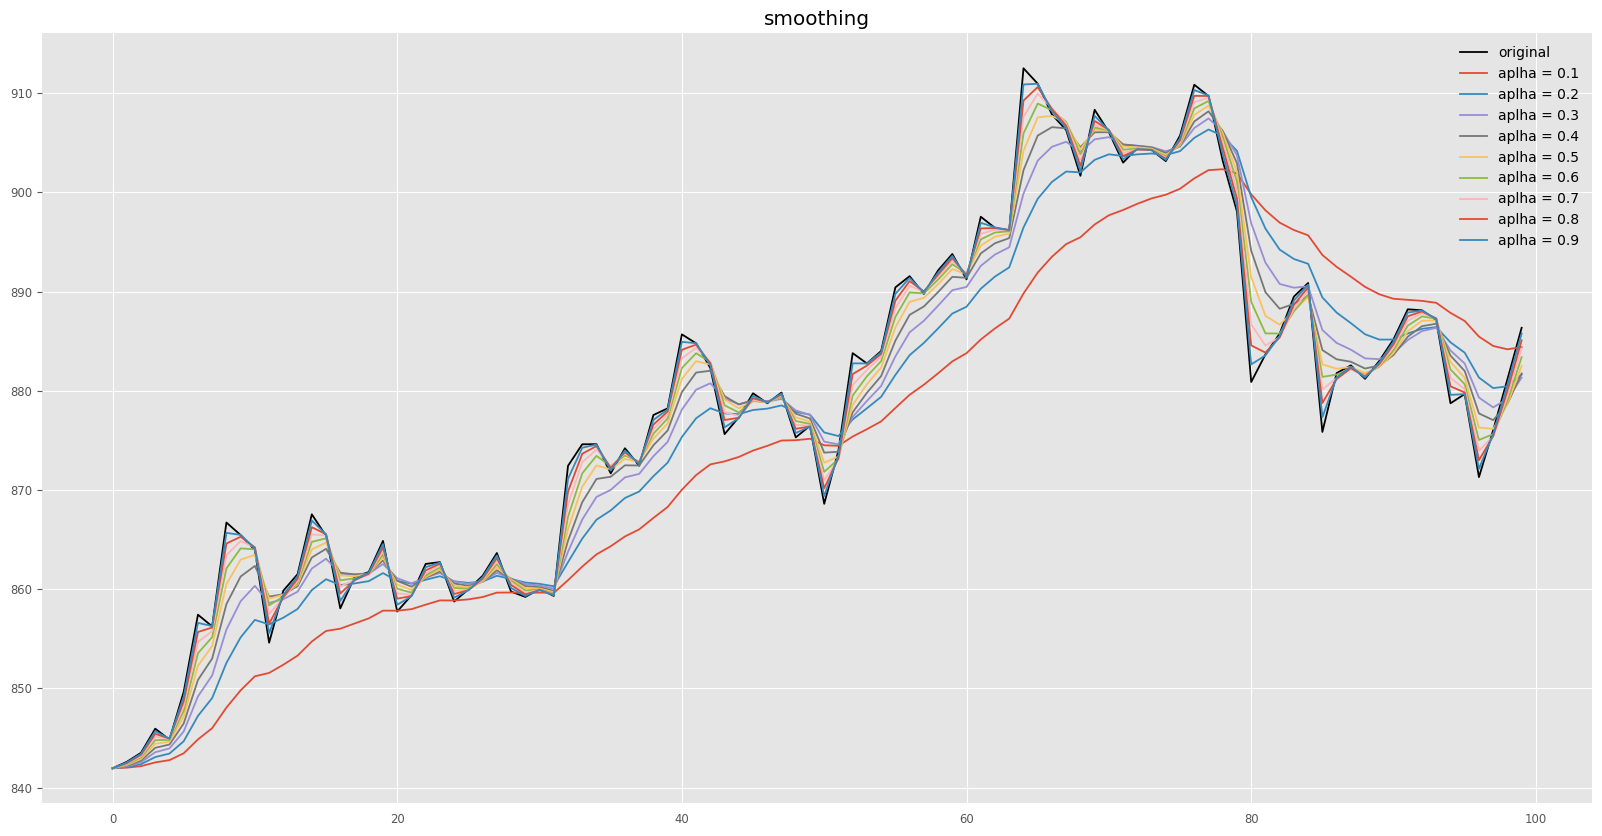

In [7]:
from smoothing import smooth

series = gold_ts[0:100]
plt.plot(range(0,100), series.values(), label=f"original", color="black")
for i in range (1,10):
    alpha = i / 10
    smoothed = smooth(series, alpha)
    plt.plot(range(0,100), smoothed.values(), label=f"aplha = {alpha}")


plt.legend(loc="upper right")
plt.title("smoothing")
plt.show()

In [8]:
my_dict = dict(zip(CONST.TICKERS,[x.pd_series() for x in ds.transformed.train]))
df = pd.DataFrame(my_dict)
df.describe()

,AEM,AUY,GFI,HMY,IAG,KGC,NEM,PAAS
count,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000
mean,0.000181,-0.000358,-0.000040,-0.000200,-0.000081,-0.000371,0.000183,0.000038
std,0.076025,0.104217,0.044539,0.104918,0.063776,0.085800,0.080161,0.091437
min,-1.000000,-1.000000,-0.508401,-0.786665,-0.610488,-1.000000,-0.725391,-0.863152
25%,-0.031750,-0.047703,-0.018463,-0.050249,-0.029770,-0.038352,-0.034395,-0.040946
50%,0.000213,-0.001888,-0.000128,-0.001764,-0.000999,-0.001488,0.000140,-0.001099
75%,0.031022,0.045772,0.017925,0.046169,0.028517,0.037202,0.034172,0.040457
max,0.876272,0.852725,1.000000,1.000000,1.000000,0.806561,1.000000,1.000000


c:\repos\nasdaq_forecasting\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


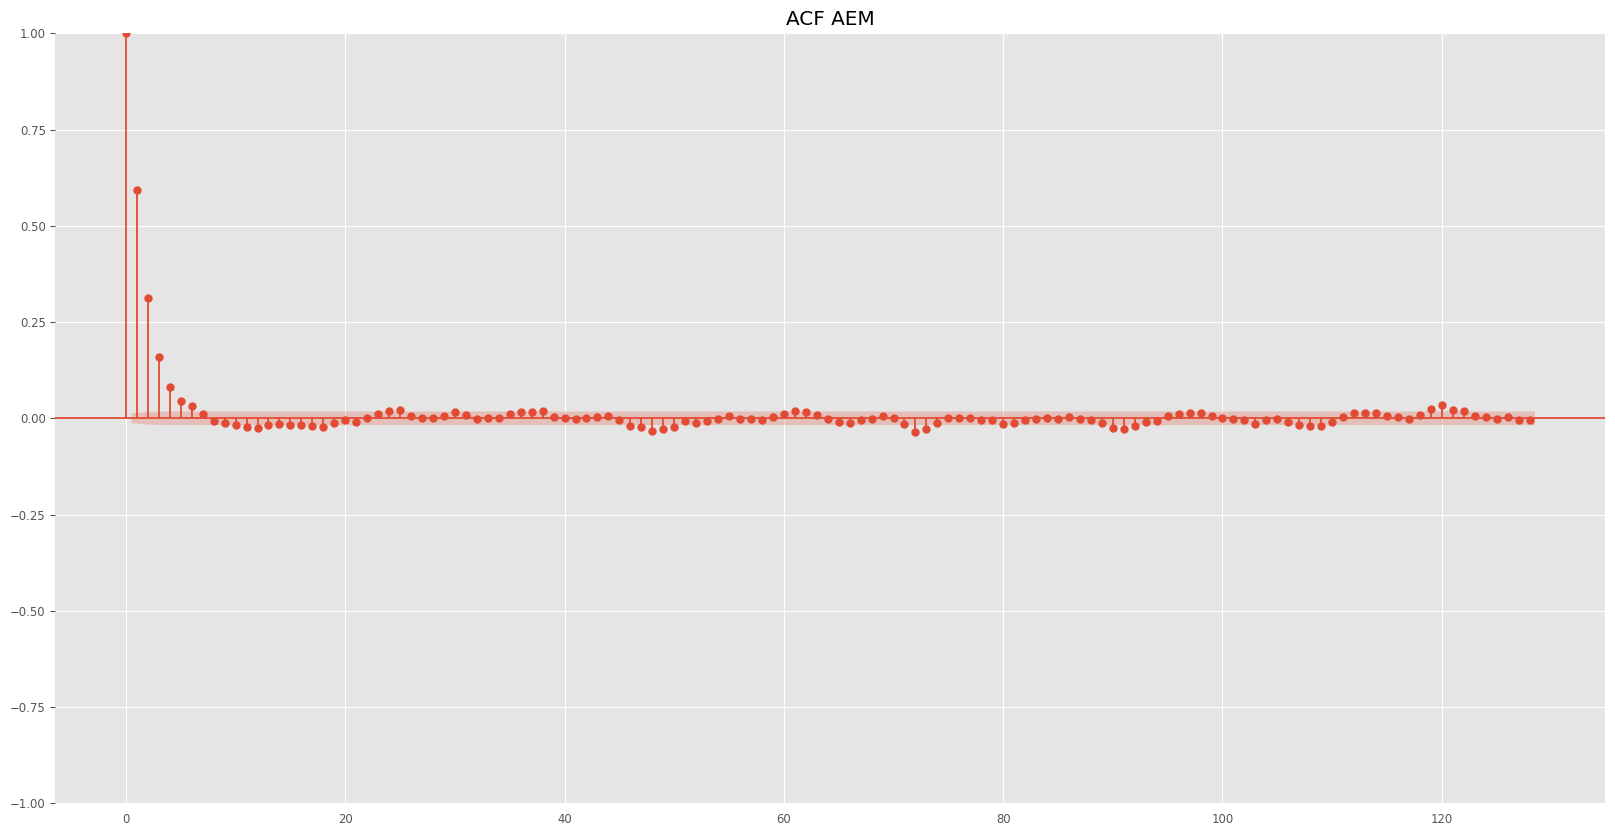

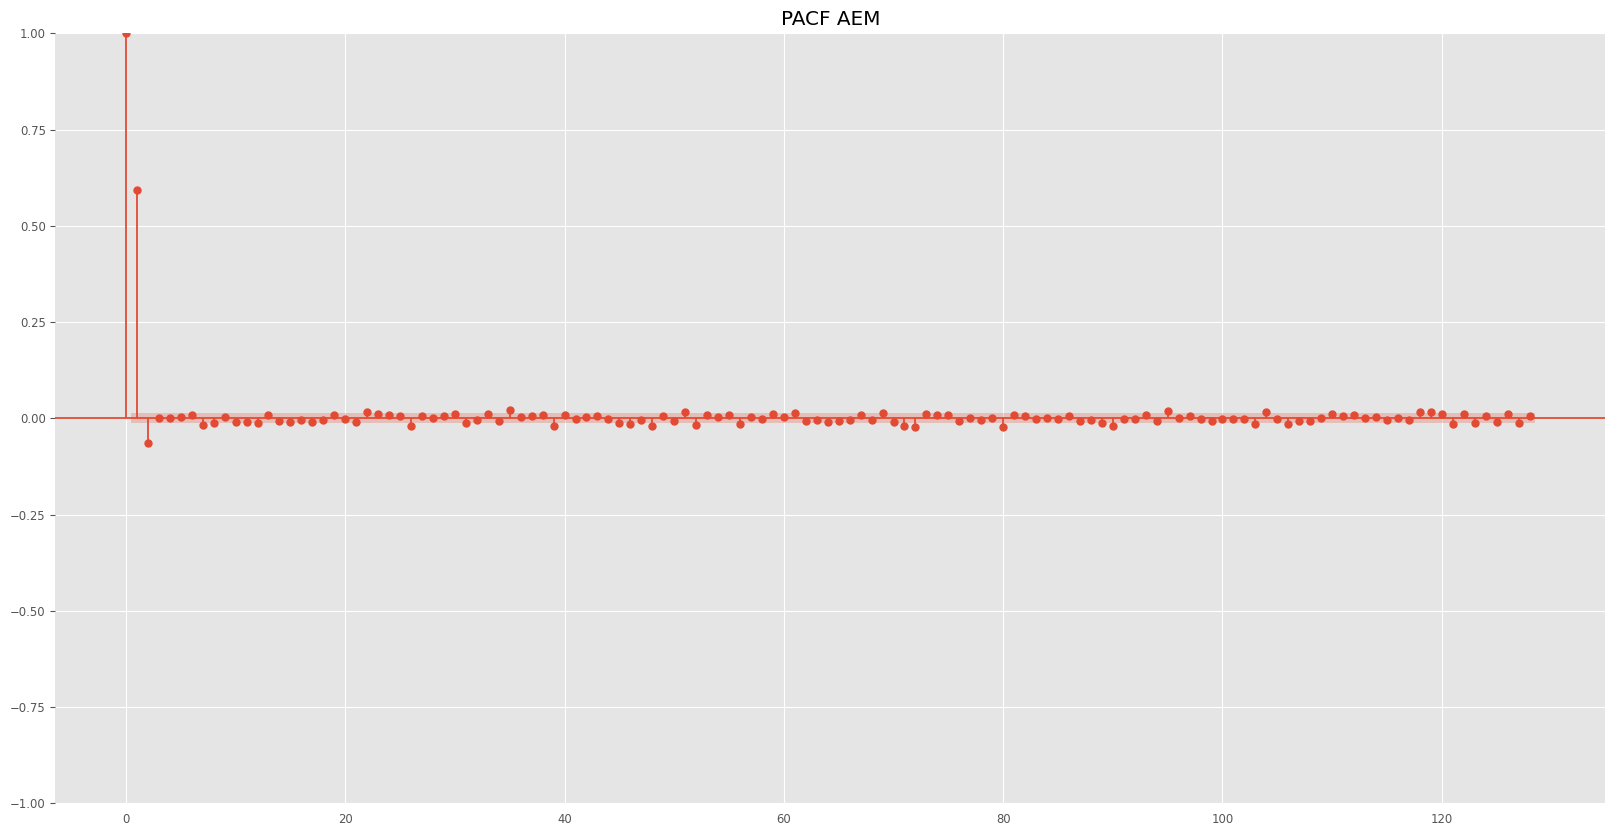

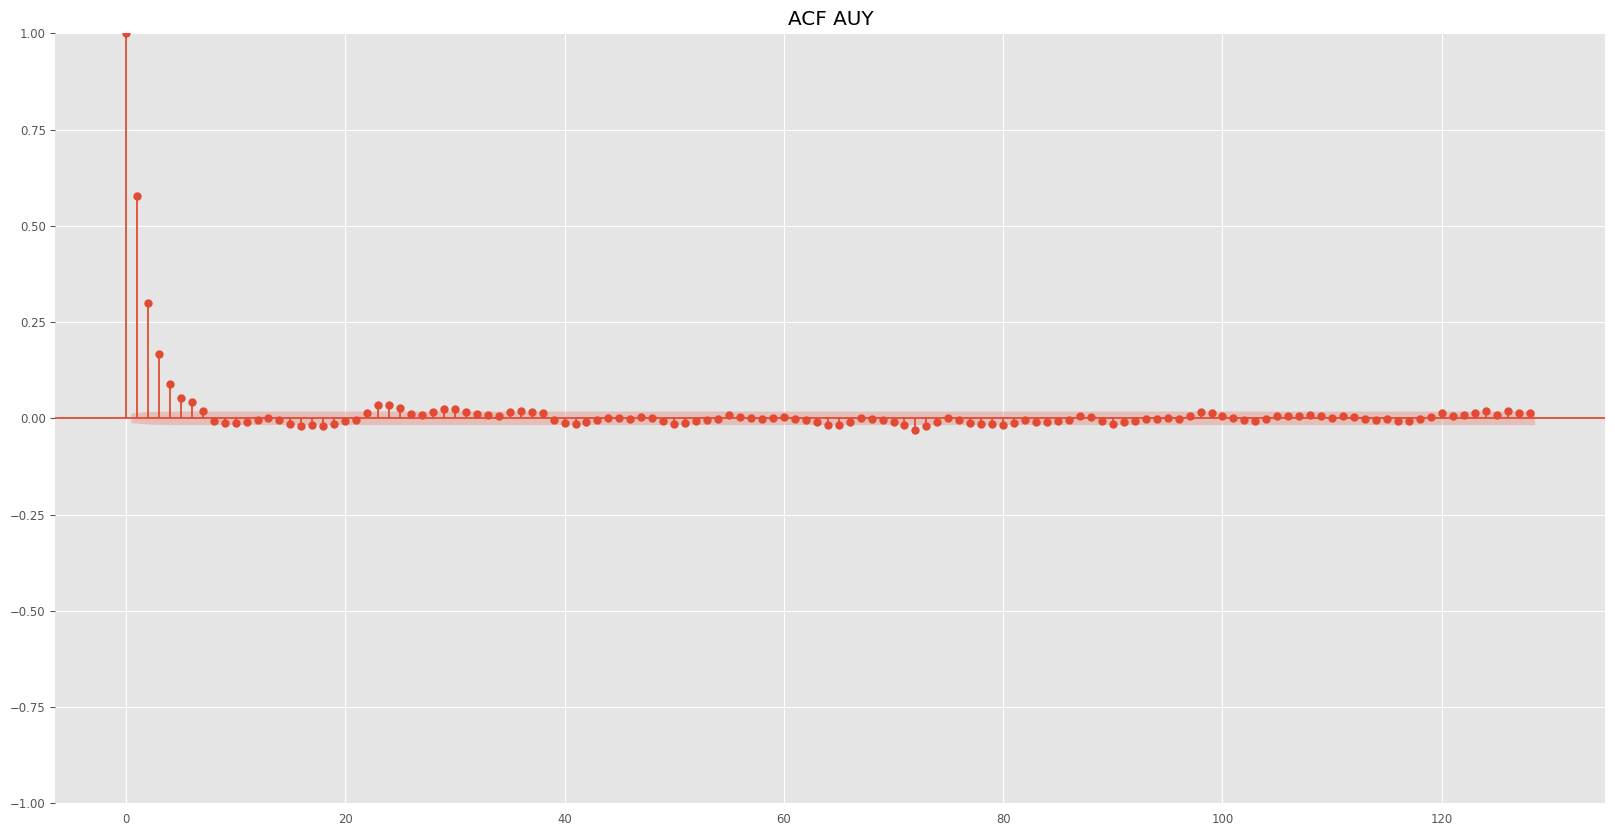

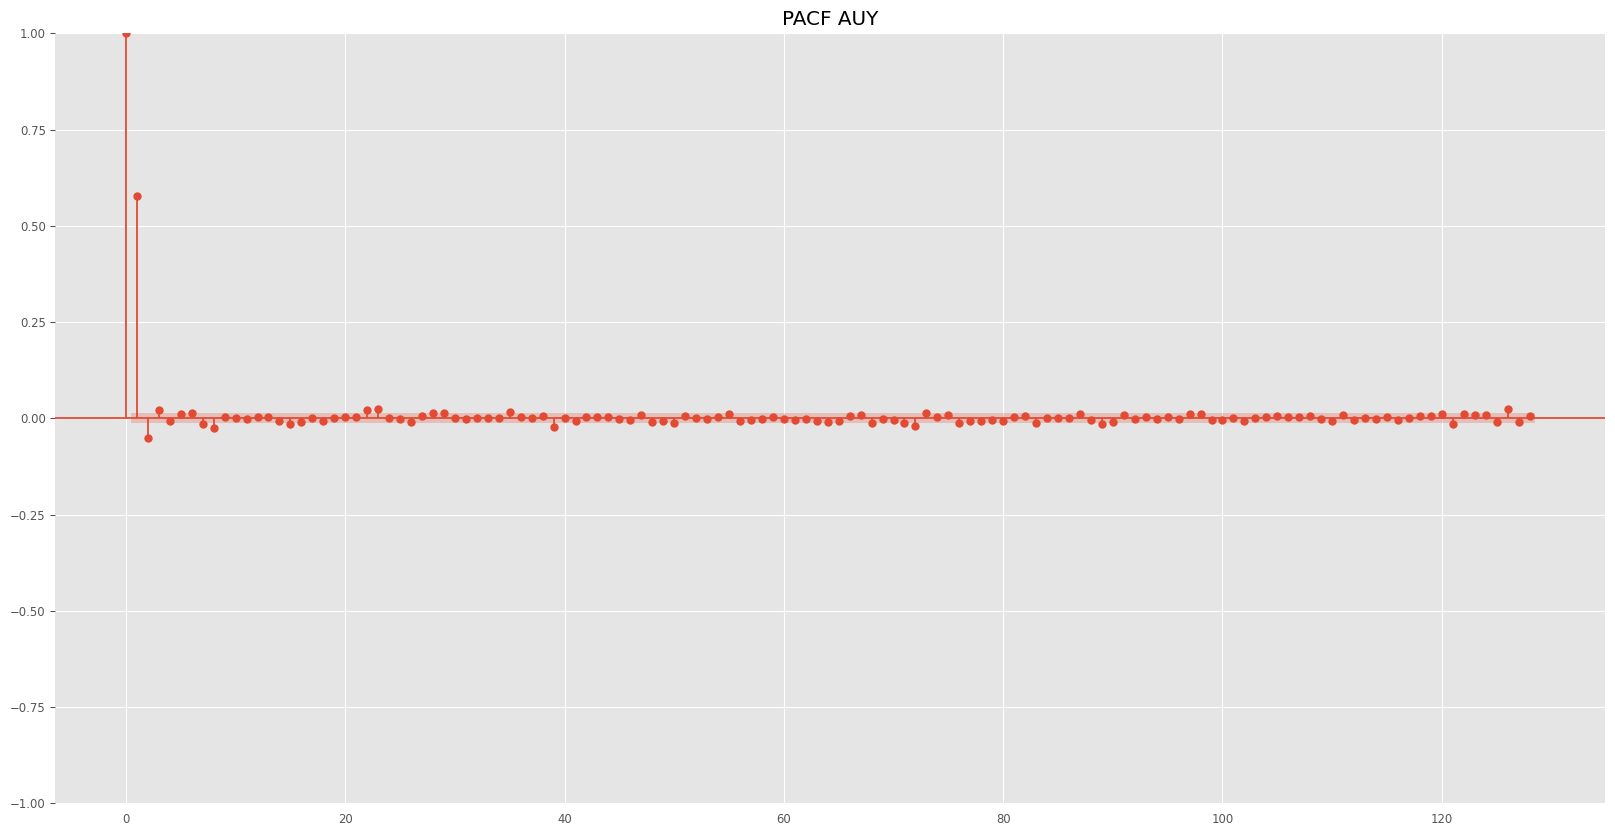

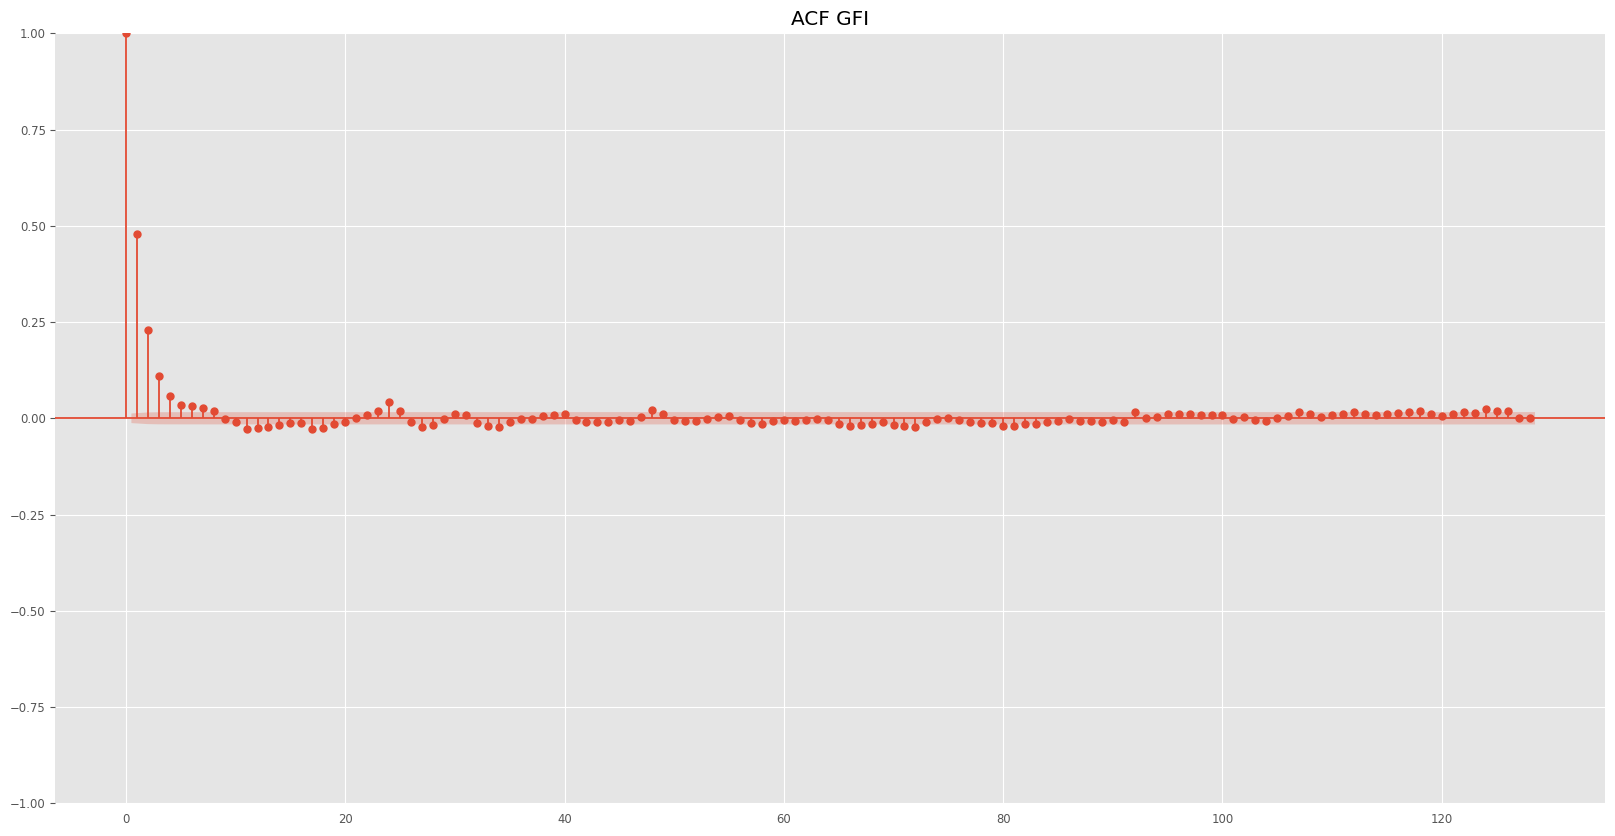

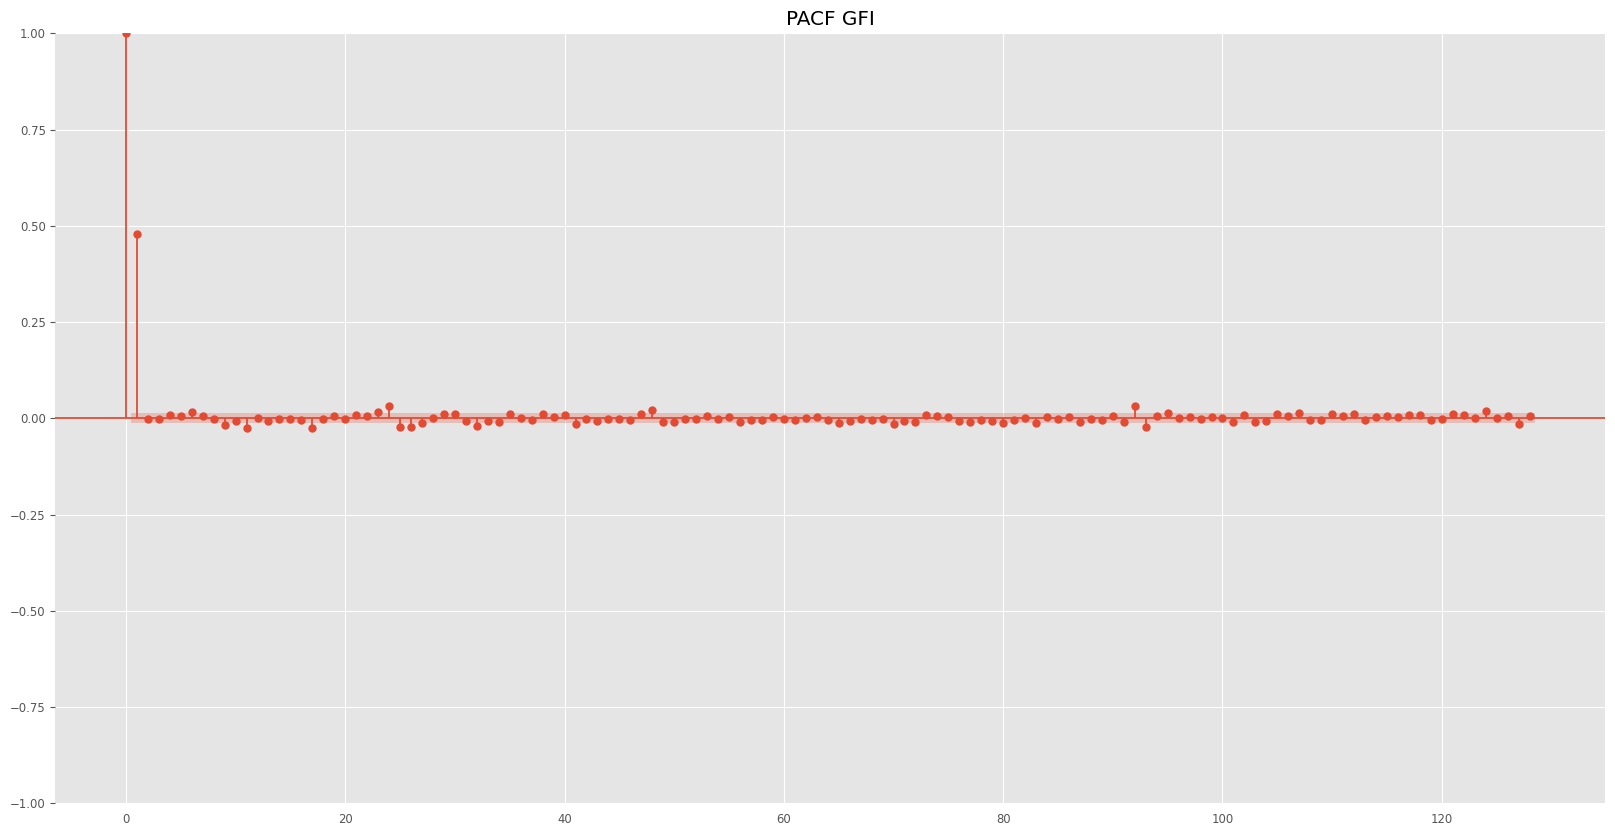

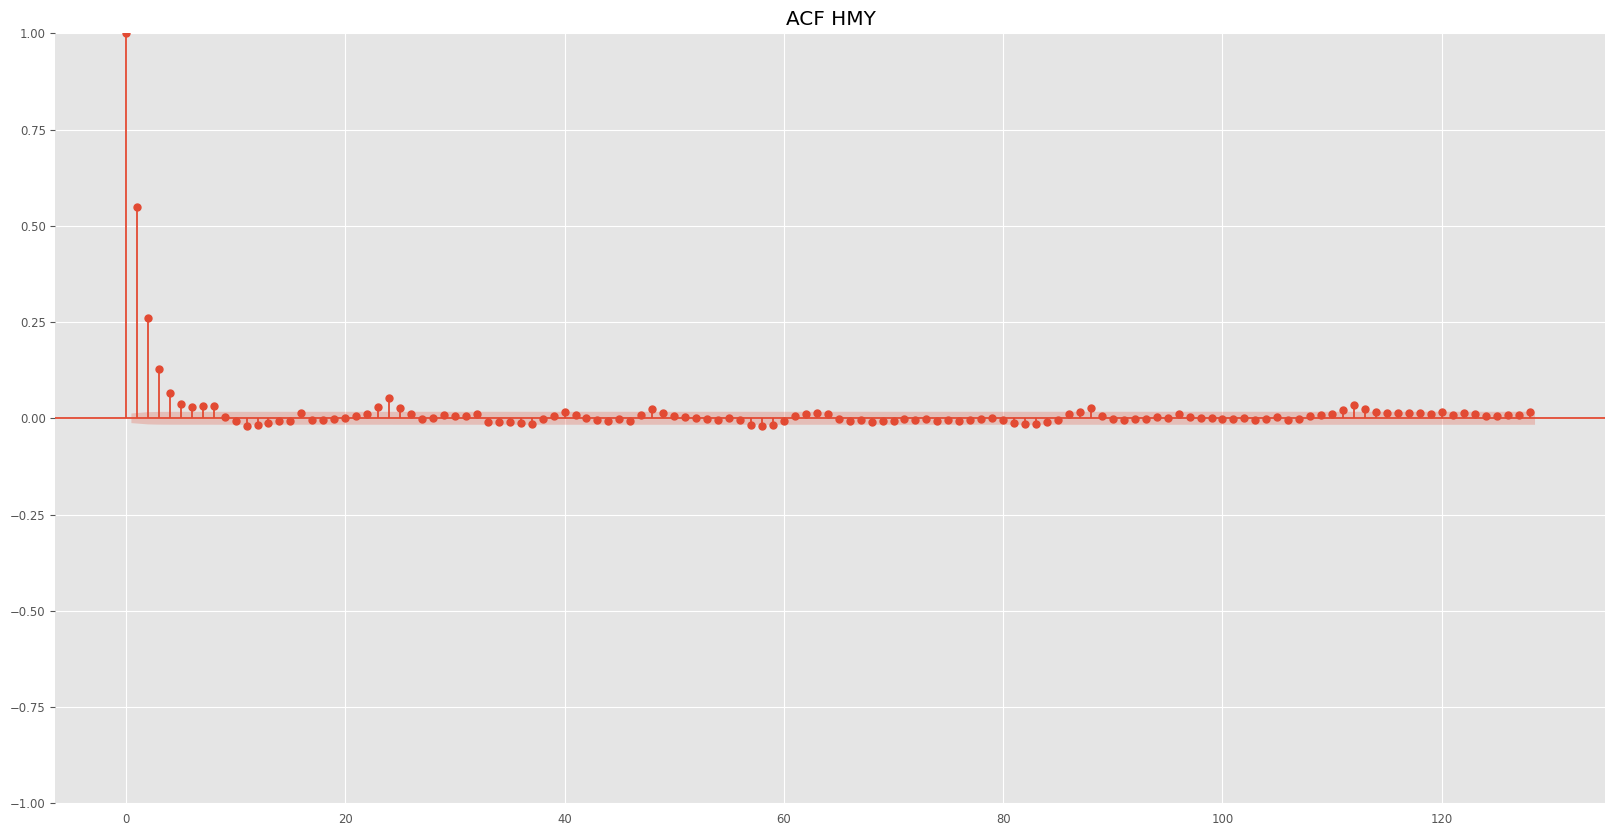

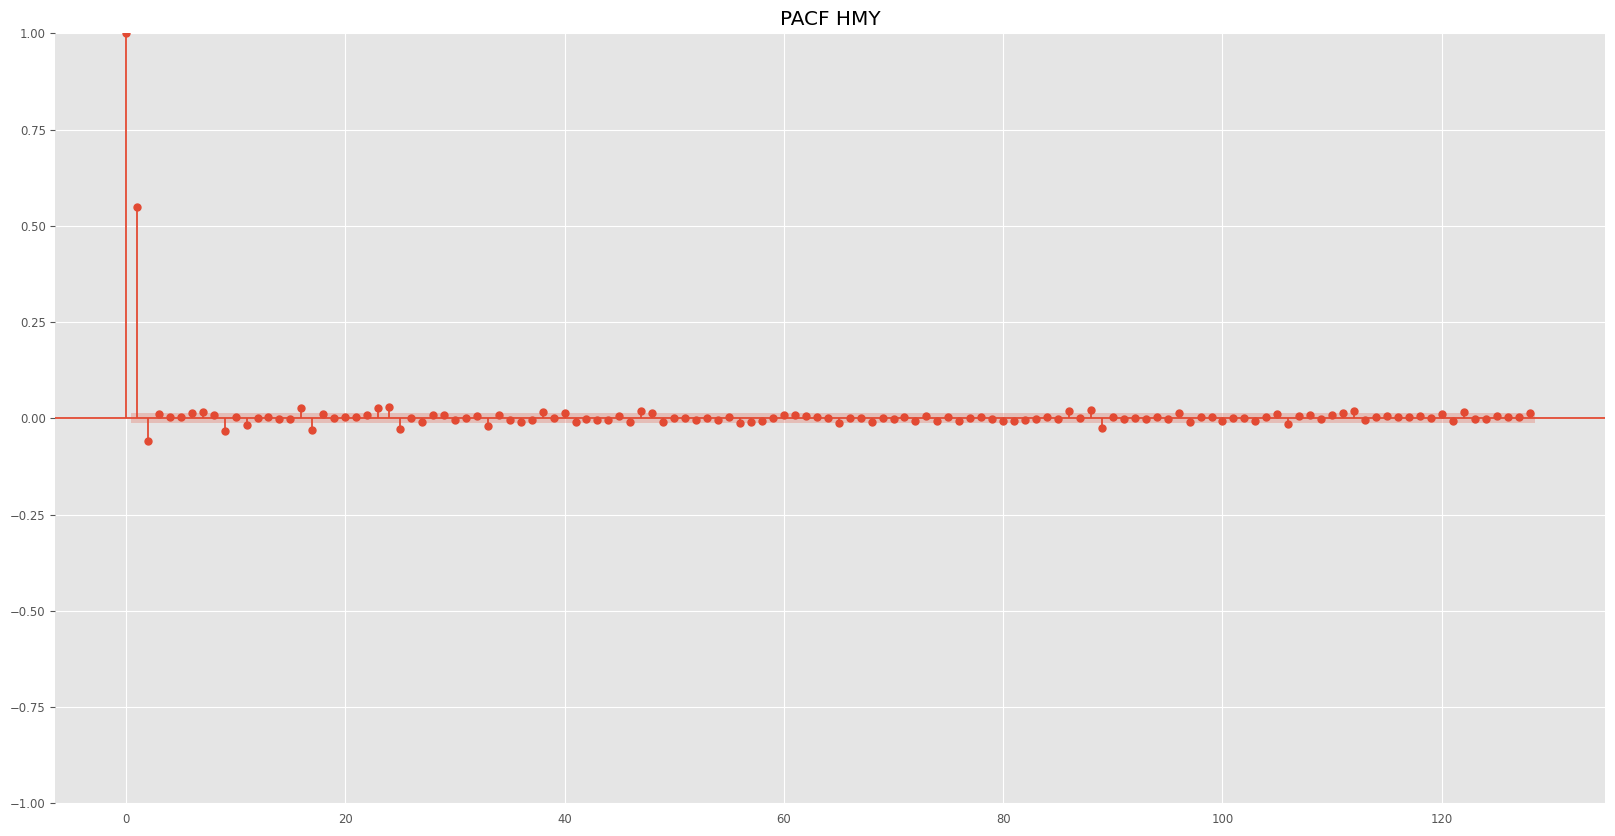

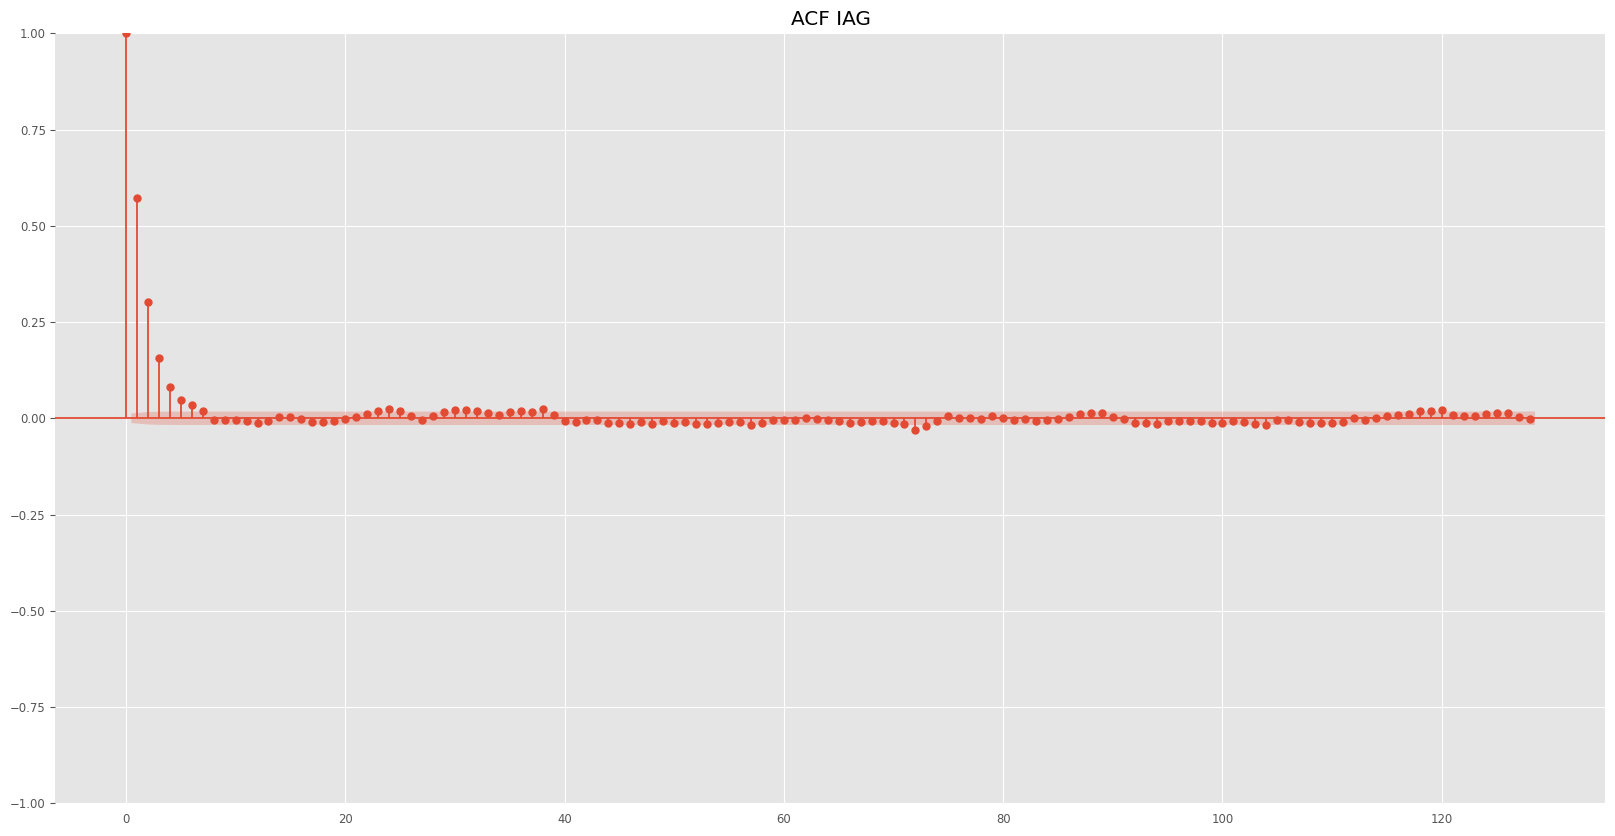

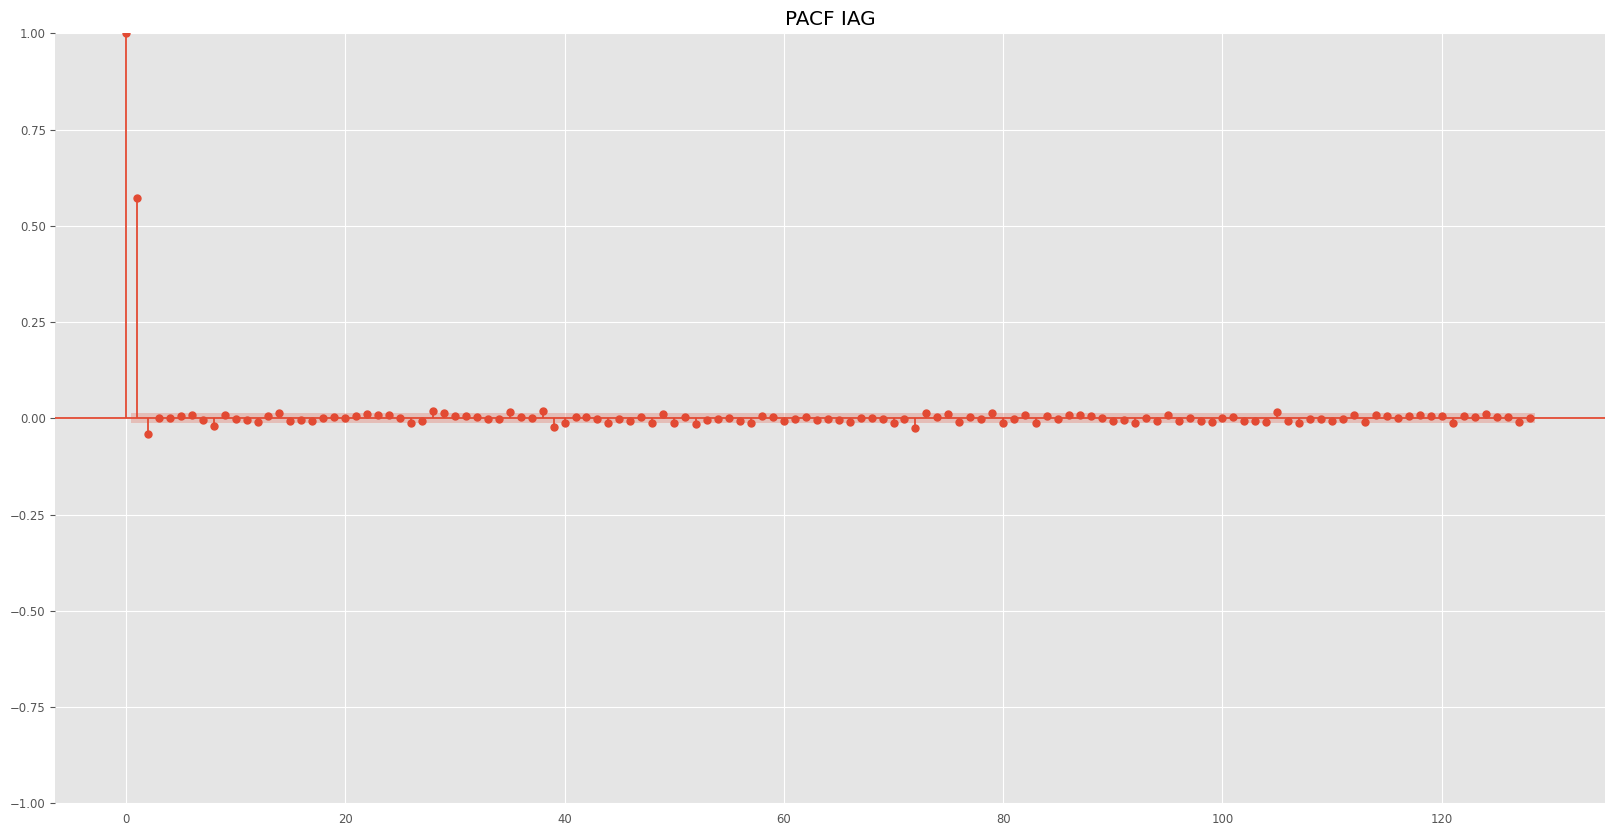

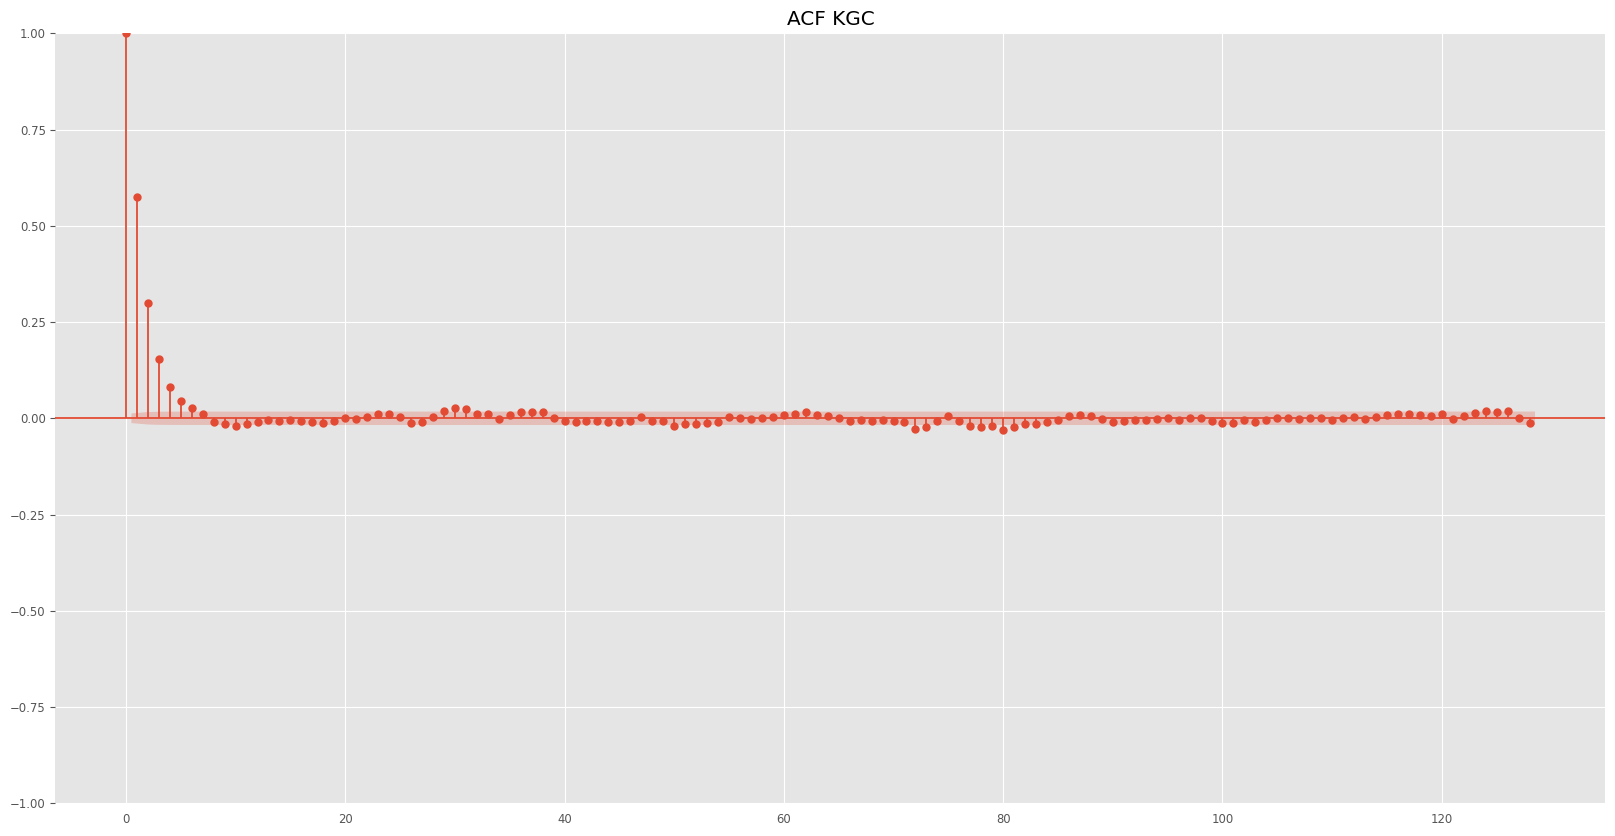

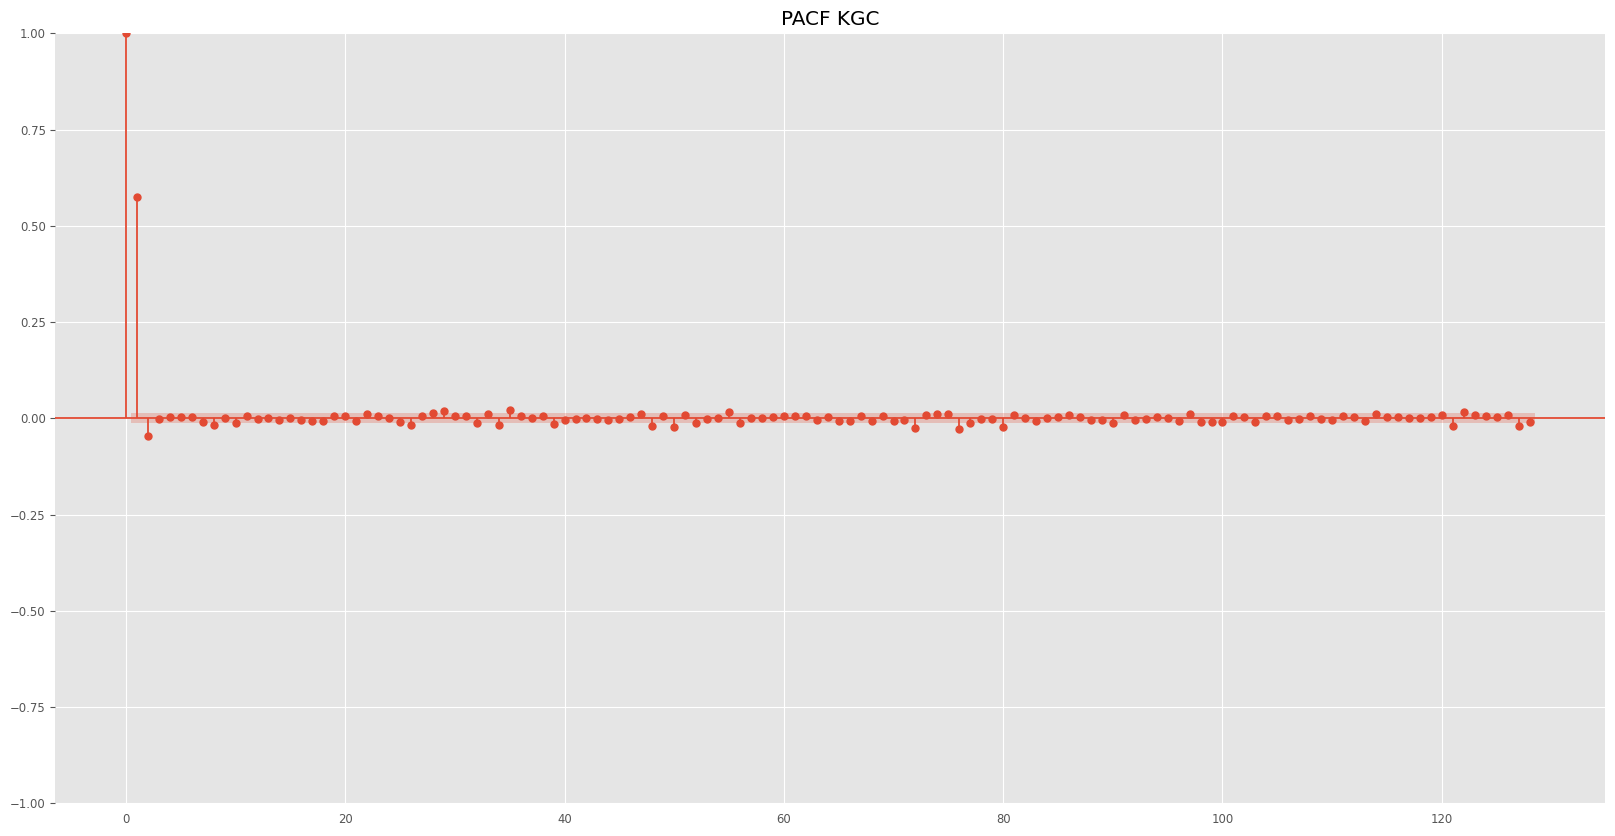

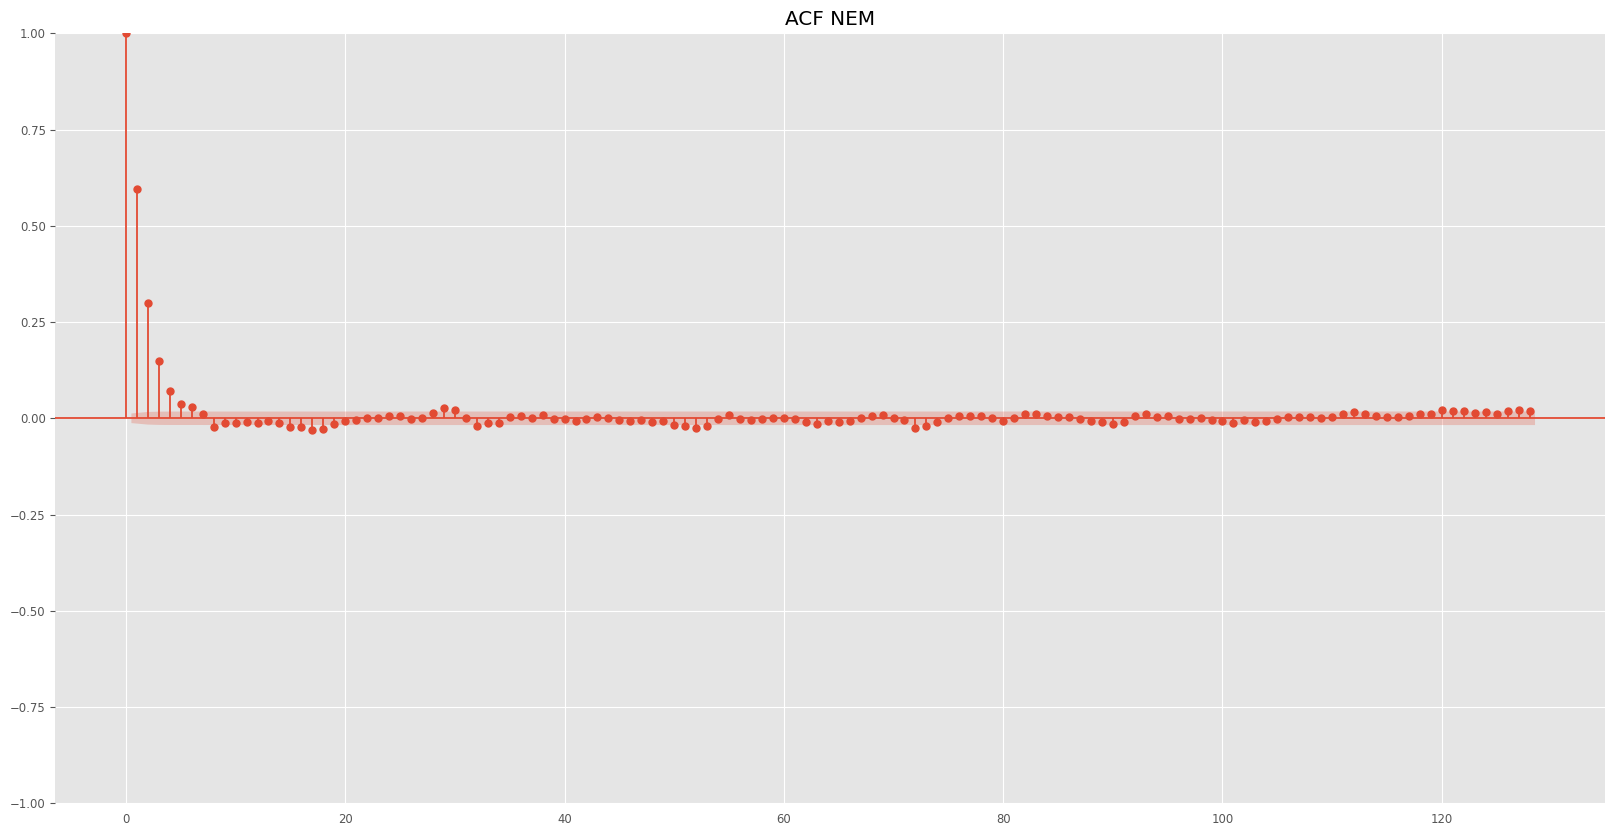

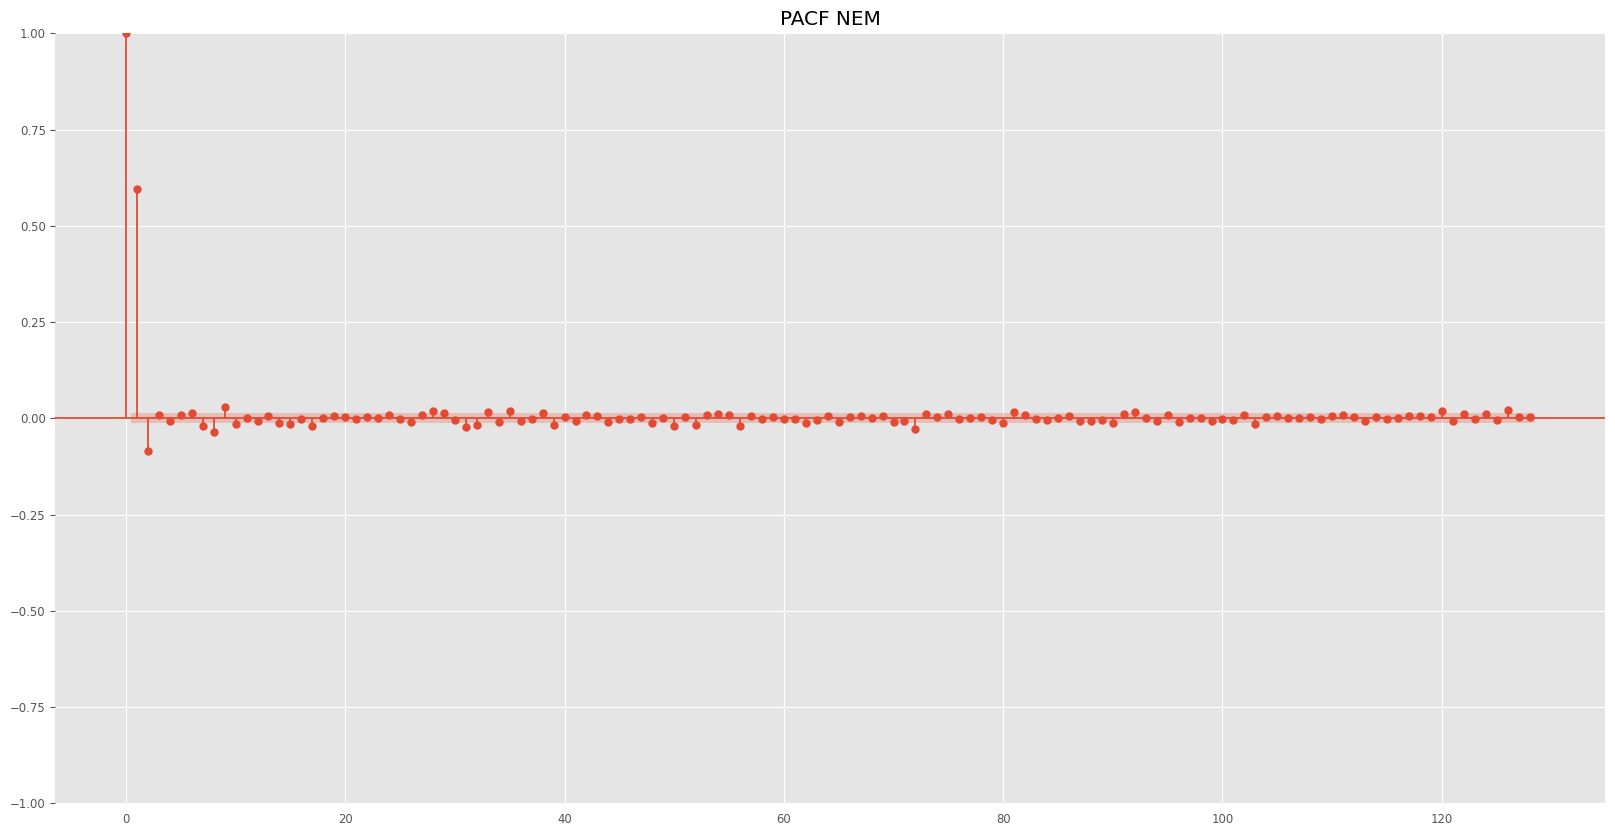

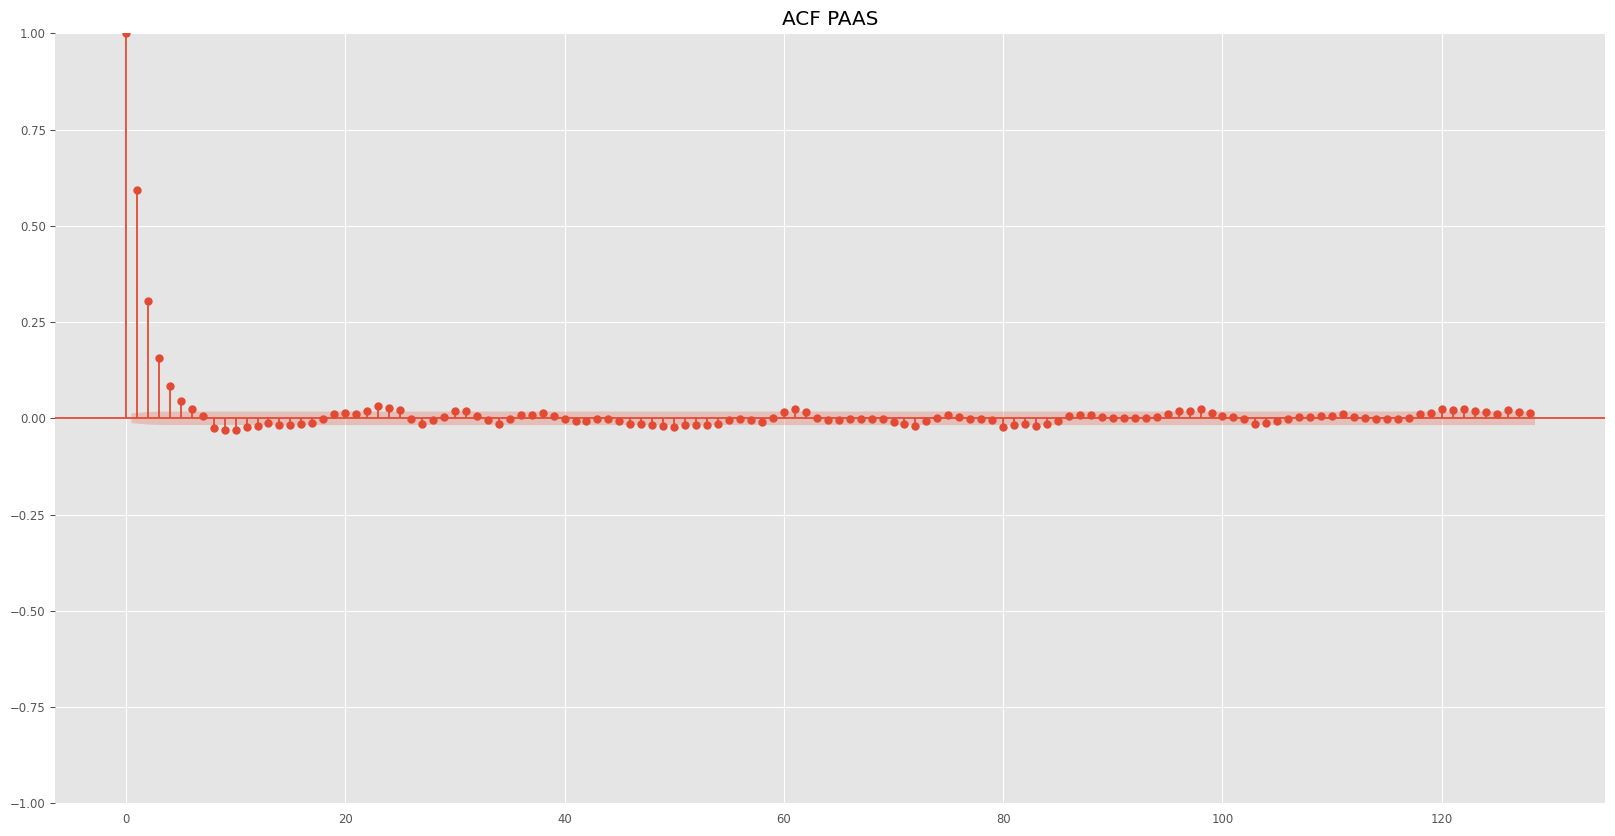

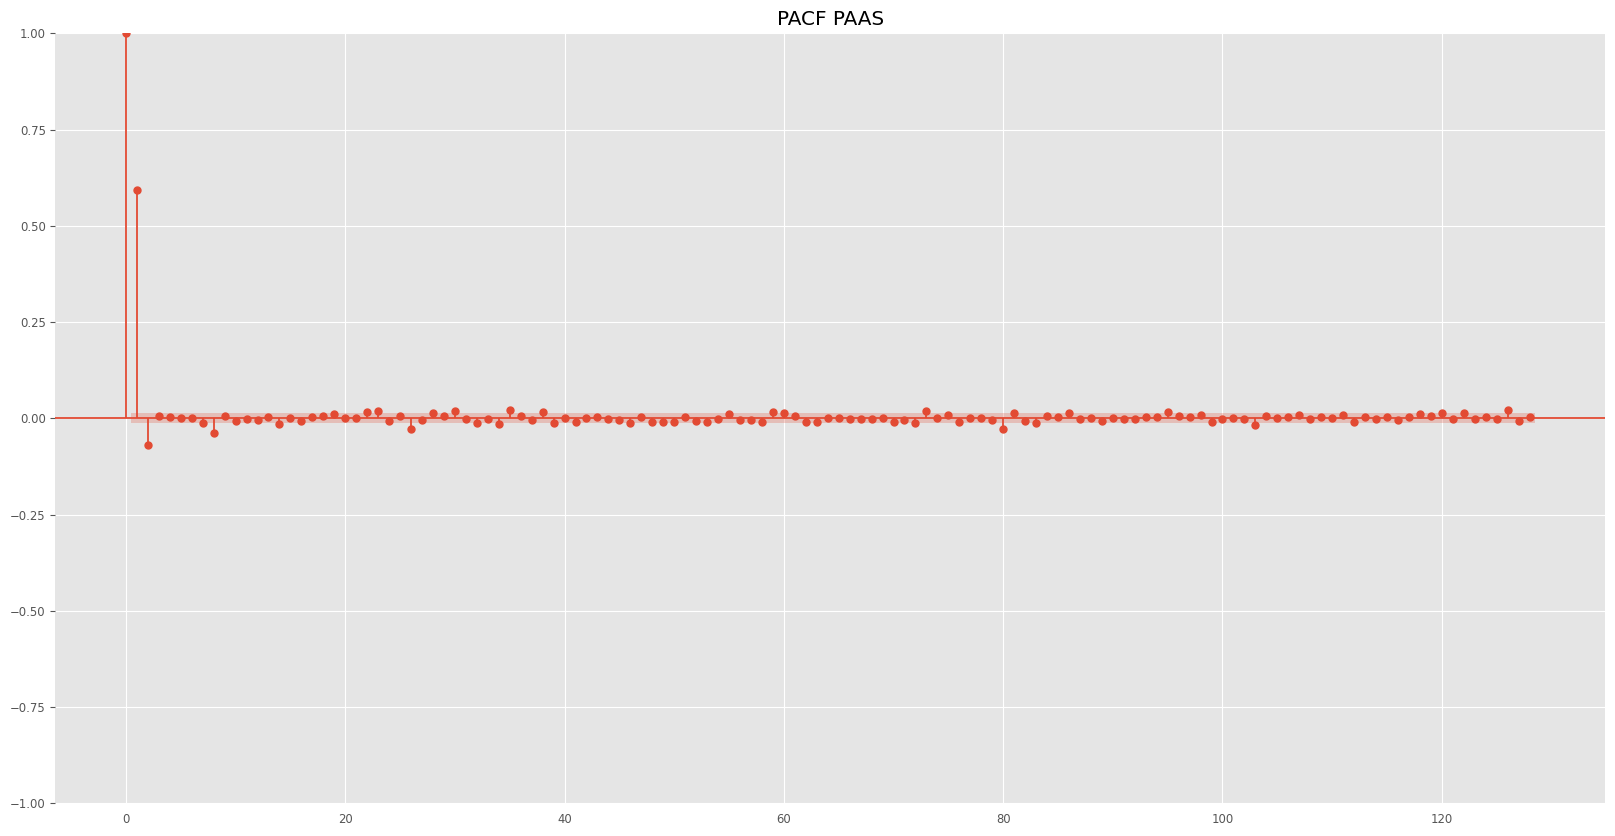

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for ticker in CONST.TICKERS:
    plot_acf(df[ticker], lags=128, title="ACF " + ticker)
    plot_pacf(df[ticker],lags=128, title="PACF " + ticker)

In [10]:
import darts.utils.statistics as statistics
# Stationary 
stats_df = pd.DataFrame({ CONST.FEATURES.PRICE: [], f"normalized {CONST.FEATURES.PRICE}": [], f" normalized {CONST.FEATURES.SHARES}": []})
p_threshold = 0.05
def test_stationarity(timeseries: TimeSeries):
    return statistics.stationarity_test_adf(timeseries)[1]

for idx,ticker in enumerate(ds.original.used_tickers):
    price_stationarity = test_stationarity(ds.original.train[idx])
    normalized_price_stationarity = test_stationarity(ds.transformed.train[idx])
    shares_stationarity = test_stationarity(ds.covariates.train[idx][CONST.FEATURES.SHARES])
    stats_df.loc[ticker] = [price_stationarity,normalized_price_stationarity,shares_stationarity]

print(stats_df)
print(stats_df < p_threshold)

         price  normalized price   normalized shares
AEM   0.046790               0.0                 0.0
AUY   0.428439               0.0                 0.0
GFI   0.371473               0.0                 0.0
HMY   0.388207               0.0                 0.0
IAG   0.630505               0.0                 0.0
KGC   0.262822               0.0                 0.0
NEM   0.298614               0.0                 0.0
PAAS  0.082010               0.0                 0.0
      price  normalized price   normalized shares
AEM    True              True                True
AUY   False              True                True
GFI   False              True                True
HMY   False              True                True
IAG   False              True                True
KGC   False              True                True
NEM   False              True                True
PAAS  False              True                True


In [11]:
correlations = df.corrwith(ds.covariates.train[0][CONST.FEATURES.GOLD_PRICE].pd_series())
print("Gold spot price correlation")
print(correlations)

Gold spot price correlation
AEM     0.323661
AUY     0.338805
GFI     0.278695
HMY     0.281028
IAG     0.293728
KGC     0.311936
NEM     0.302634
PAAS    0.301010
dtype: float64


In [13]:
price_shares_corr = []
for column in df.columns:
    corr = df[column].corr(ds.covariates.train[idx][CONST.FEATURES.SHARES].pd_series())
    price_shares_corr.append(corr)

In [14]:
print(price_shares_corr)

[0.008781997583689024, 0.010268941885504626, 0.009187724781002429, 0.0036559619137923743, 0.008870633667040391, 0.012344009035849084, 0.007983336117212162, 0.008996640354166602]
